In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import glob
import gc
import string
from unicodedata import normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import shuffle
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from keras.models import Model
from keras.layers import Layer
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Concatenate
from keras import optimizers
from keras.callbacks import EarlyStopping

import nltk
from nltk.tokenize import RegexpTokenizer
import spacy


# Carregar Dados

In [ ]:
files=glob.glob('../archive/*.csv')
files

['../archive/parque_nacional_iguacu.csv',
 '../archive/parque_chapada_dos_veadeiros.csv',
 '../archive/museu_imperial.csv',
 '../archive/mercado-central-fortaleza-ce.csv',
 '../archive/jardim_botanico.csv',
 '../archive/aqua-rio-rj.csv',
 '../archive/mercado-ver-o-peso-pa.csv',
 '../archive/praia-copacabana-rj.csv',
 '../archive/elevador_lacerda.csv',
 '../archive/pelourinho_ba.csv',
 '../archive/museu_arte_sp.csv',
 '../archive/praca-3-poderes-br.csv',
 '../archive/parque_jalapao.csv',
 '../archive/hopi_hari.csv',
 '../archive/beto-carreiro-sc.csv']

In [ ]:
#dados será um dicionário com os comentários e as notas de cada usuário
# as chaves do dicionário serão os nomes dos destinos turísticos

dados={}

for file in files:
    dados[file.split('/')[-1].split('.')[0]]=pd.read_csv(file, delimiter=';')



In [ ]:
dados.keys()
nomes_destinos=list(dados.keys())

In [ ]:
print('Destinos turísticos avaliados:')
print('')
for nome_destino in nomes_destinos:
    print(nome_destino)

Destinos turísticos avaliados:

parque_nacional_iguacu
parque_chapada_dos_veadeiros
museu_imperial
mercado-central-fortaleza-ce
jardim_botanico
aqua-rio-rj
mercado-ver-o-peso-pa
praia-copacabana-rj
elevador_lacerda
pelourinho_ba
museu_arte_sp
praca-3-poderes-br
parque_jalapao
hopi_hari
beto-carreiro-sc


# Análise Exploratória - Notas

## Comparativo entre as notas dos destinos turísticos

'''
Nessa seção será feito um comparativo entre as avaliações (somente das notas) recebidas por cada uma das atrações.
As atrações foram avaliadas com notas variando entre 1 e 5, sendo 5 a melhor nota.
'''

In [ ]:
#Verificando a existência de entradas nulas
print('Número de entradas nulas para as notas das atrações:')
print('')
for nome in nomes_destinos:
    print(nome+ ' : {}'.format(dados[nome]['nota'].isnull().sum()))

Número de entradas nulas para as notas das atrações:

parque_nacional_iguacu : 0
parque_chapada_dos_veadeiros : 0
museu_imperial : 0
mercado-central-fortaleza-ce : 0
jardim_botanico : 0
aqua-rio-rj : 0
mercado-ver-o-peso-pa : 0
praia-copacabana-rj : 0
elevador_lacerda : 0
pelourinho_ba : 0
museu_arte_sp : 0
praca-3-poderes-br : 0
parque_jalapao : 0
hopi_hari : 0
beto-carreiro-sc : 0


### Nota média de cada destino turistico

In [ ]:
dados_nota_media={}
for destino in nomes_destinos:
    dados_nota_media[destino]=dados[destino]['nota'].mean()
dados_nota_media=pd.DataFrame.from_dict(dados_nota_media,orient='index').rename(columns={0:'Nota_Média'}).sort_values(by='Nota_Média',ascending=False)
dados_nota_media.index.rename('Destino',inplace=True)
dados_nota_media

,Nota_Média
Destino,
parque_nacional_iguacu,4.837884
parque_chapada_dos_veadeiros,4.788469
parque_jalapao,4.781955
museu_imperial,4.655708
jardim_botanico,4.628761
museu_arte_sp,4.554544
praia-copacabana-rj,4.371347
praca-3-poderes-br,4.250324
aqua-rio-rj,4.127649


<AxesSubplot:title={'center':'Nota média de cada destino'}, xlabel='Destino', ylabel='Nota_Média'>

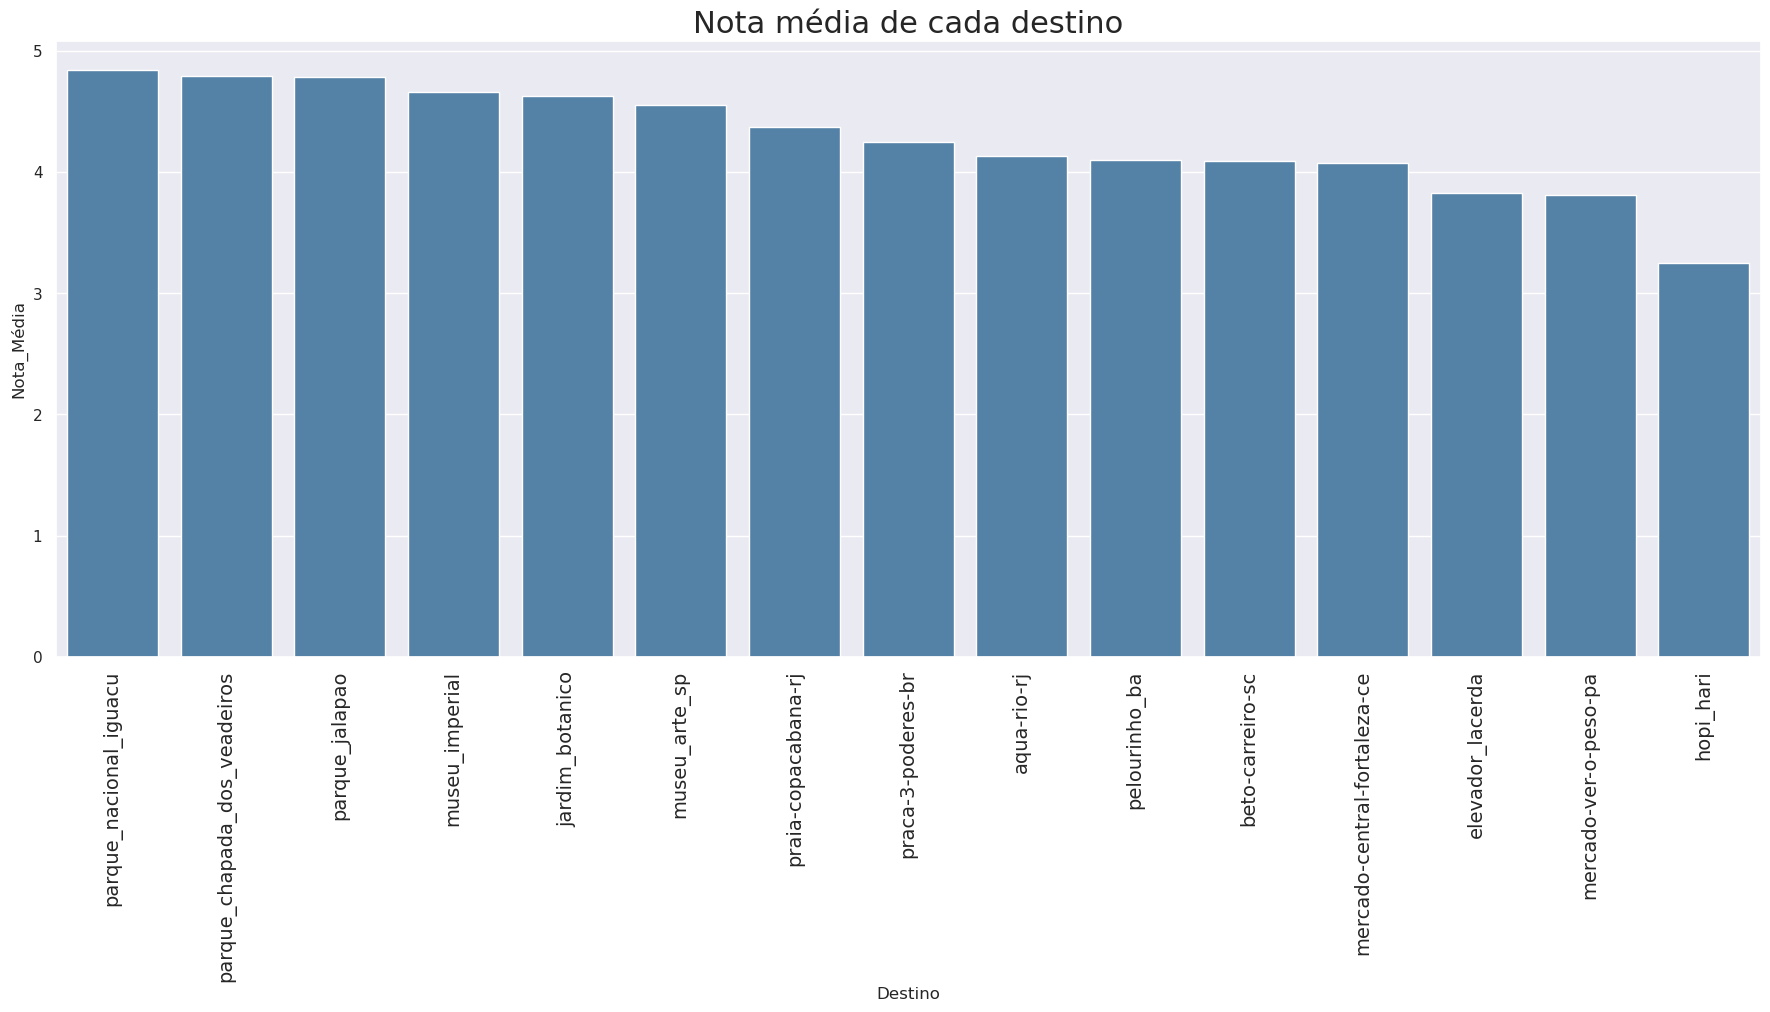

In [ ]:
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.title('Nota média de cada destino',fontsize = 22)
plt.xticks(rotation=90,fontsize=14)
sns.barplot(dados_nota_media,x=dados_nota_media.index,y='Nota_Média',color='steelblue')



### Proporção de avaliações com cada nota para cada destino turístico

In [ ]:
#Calcular a proporção das notas em relação ao número de avaliações
proporcao_notas=[]
for destino in nomes_destinos:
    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))
    proporcao_notas+=[[(dados[destino]['nota']==nota).sum() for nota in [1,2,3,4,5]]]
proporcao_notas=pd.DataFrame(proporcao_notas,index=nomes_destinos)
proporcao_notas["Total Avaliações"]=proporcao_notas.sum(axis=1)
proporcao_notas.iloc[:,:5]=proporcao_notas.iloc[:,:5].div(proporcao_notas["Total Avaliações"],axis=0)
proporcao_notas.columns=   ['nota 1(%)',
                            'nota 2(%)',
                            'nota 3(%)',
                            'nota 4(%)',
                            'nota 5(%)',
                             "Total Avaliações"]

In [ ]:
#O dataframe proporcao_notas exibe o total de avaliações de cada destino turístico e a proporção desse total correspondentes as
#notas 1,2,3,4 e 5
proporcao_notas

,nota 1(%),nota 2(%),nota 3(%),nota 4(%),nota 5(%),Total Avaliações
parque_nacional_iguacu,0.001532,0.001892,0.011715,0.126881,0.857980,11097
parque_chapada_dos_veadeiros,0.002203,0.003672,0.021667,0.148366,0.824091,2723
museu_imperial,0.002822,0.005080,0.034994,0.247778,0.709327,7087
mercado-central-fortaleza-ce,0.012190,0.028059,0.194112,0.402254,0.363385,4348
jardim_botanico,0.001403,0.003724,0.050498,0.253458,0.690916,20674
aqua-rio-rj,0.025720,0.048583,0.150750,0.322220,0.452727,4199
mercado-ver-o-peso-pa,0.046576,0.079845,0.222345,0.319379,0.331855,3607
praia-copacabana-rj,0.011091,0.023617,0.117563,0.278314,0.569415,7664
elevador_lacerda,0.026991,0.064808,0.278066,0.317959,0.312176,6743
pelourinho_ba,0.024637,0.040003,0.165692,0.352347,0.417321,11974


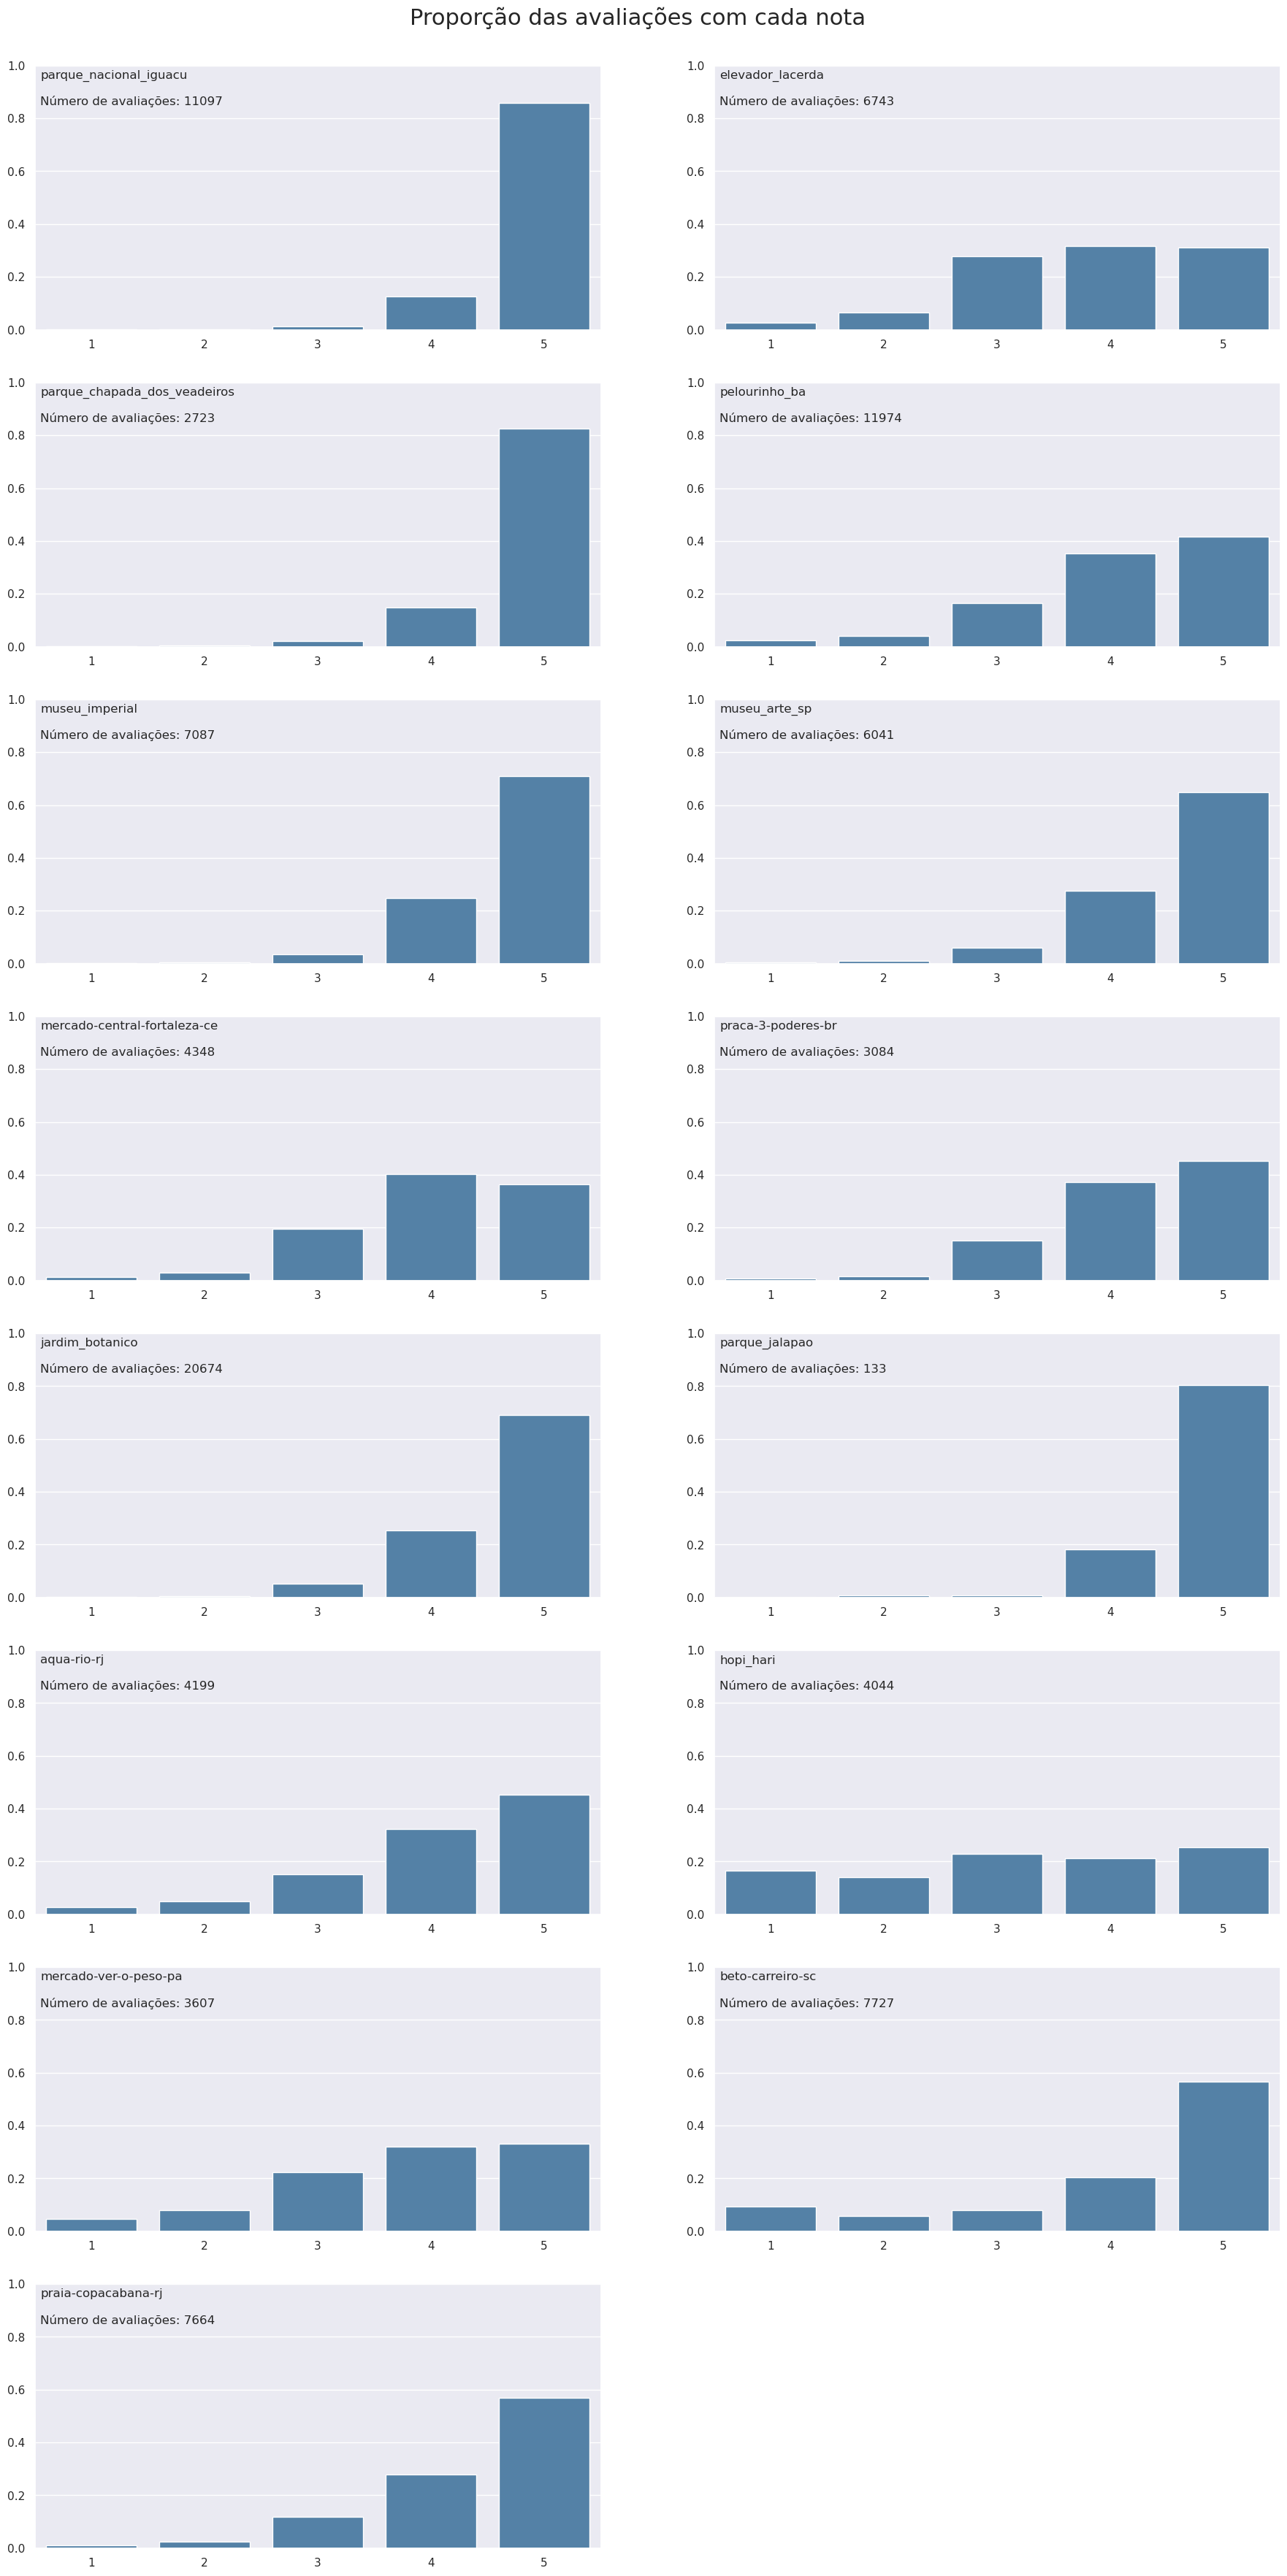

In [ ]:
#Plotar graficos com as proporções das avaliações para cada destino
fig,axs=plt.subplots(8,2,figsize=(22,40))
plt.subplots_adjust(top=0.96) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Proporção das avaliações com cada nota', fontsize=22) #adiciona um título geral para os subplots
row_subplot=0
col_subplot=0
for num_destino in range(len(proporcao_notas)):
    destino=proporcao_notas.index[num_destino]
    sns.set_theme(style='darkgrid')
    ax=sns.barplot(x=[1,2,3,4,5],y=proporcao_notas.iloc[num_destino,:5],ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, destino)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(proporcao_notas.loc[destino,'Total Avaliações']))
    ax.set(ylabel=None)
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])


### Proporção de avaliações positivas, negativas e neutras

In [ ]:
#Criação de dataframe com proporção de avaliações negativas, neutras e positivas

#Avaliação negativa - notas 1 e 2
#Avaliação neutra   - nota 3
#Avaliação positiva - notas 4 e 5


pos_neutra_neg=pd.concat((proporcao_notas.iloc[:,:2].sum(axis=1),
                          proporcao_notas.iloc[:,2],
                          proporcao_notas.iloc[:,3:5].sum(axis=1)),axis=1)
pos_neutra_neg.columns=['Negativas(%)',
                        'Neutras(%)',
                        'Positivas(%)']

pos_neutra_neg.sort_values(by=['Positivas(%)'],ascending=False,inplace=True)
pos_neutra_neg.index.rename('Destino',inplace=True)

[[<matplotlib.axis.YTick at 0x7f4377c44490>,

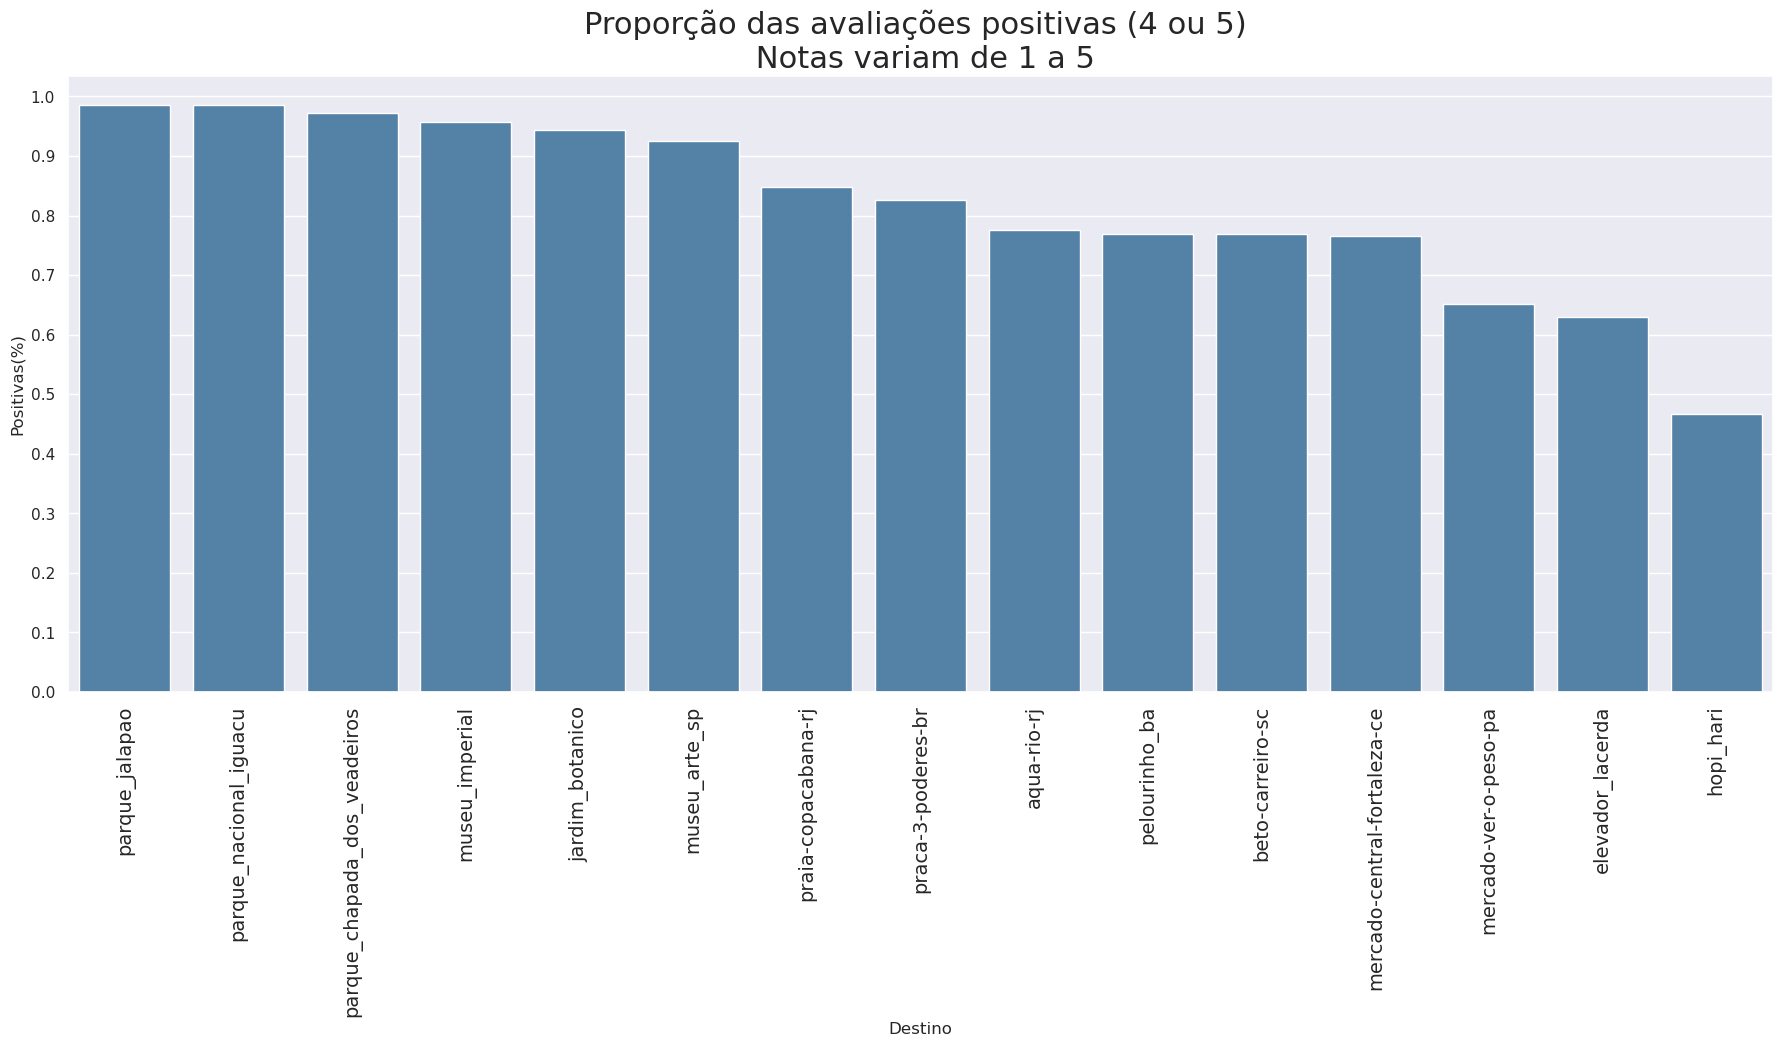

In [ ]:
# Criação de gráfico para comparação entre a proporção das avaliações positivas
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações positivas (4 ou 5) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Positivas(%)'],ascending=False,inplace=True),x=pos_neutra_neg.index,y=pos_neutra_neg['Positivas(%)'],color='steelblue')
g.set(yticks=np.arange(0,1.1,0.1))


[[<matplotlib.axis.YTick at 0x7f4377bbd650>,

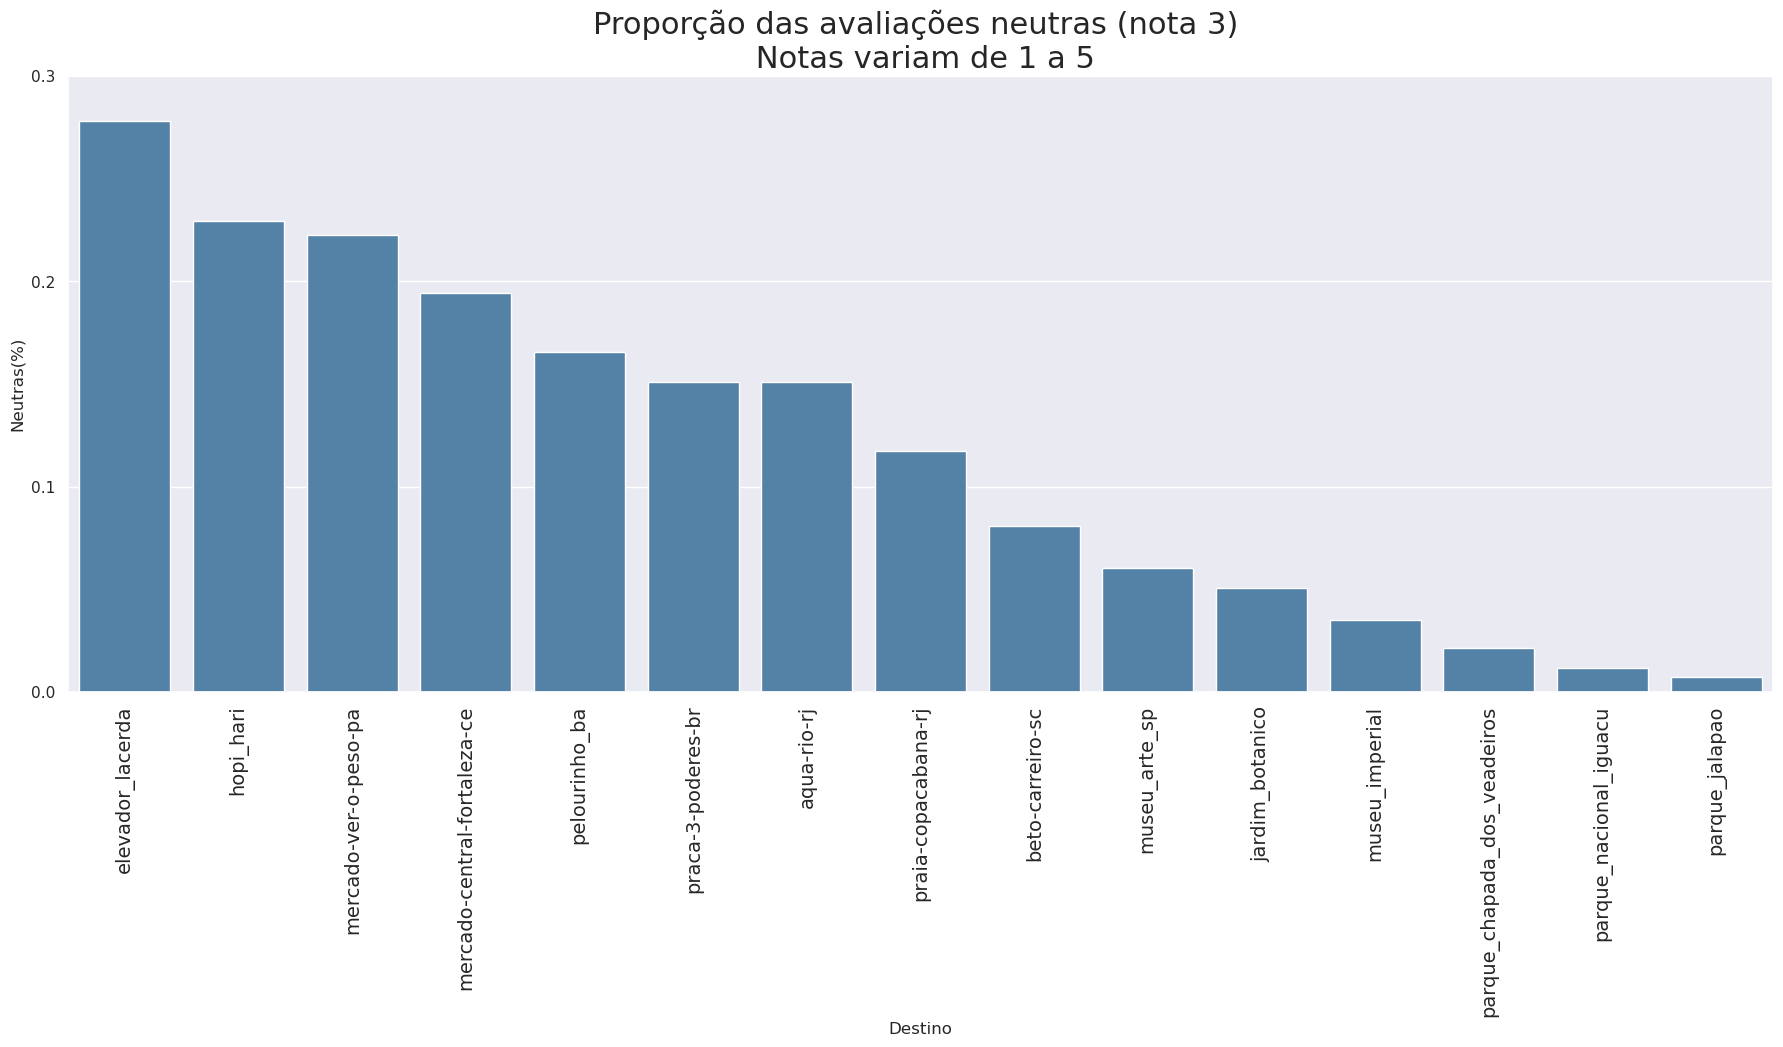

In [ ]:
# Criação de gráfico para comparação entre a proporção das avaliações neutras
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações neutras (nota 3) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Neutras(%)'],ascending=False,inplace=True),x=pos_neutra_neg.index,
              y=pos_neutra_neg['Neutras(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.4,0.1))


Text(0.5, 0, 'Destino')

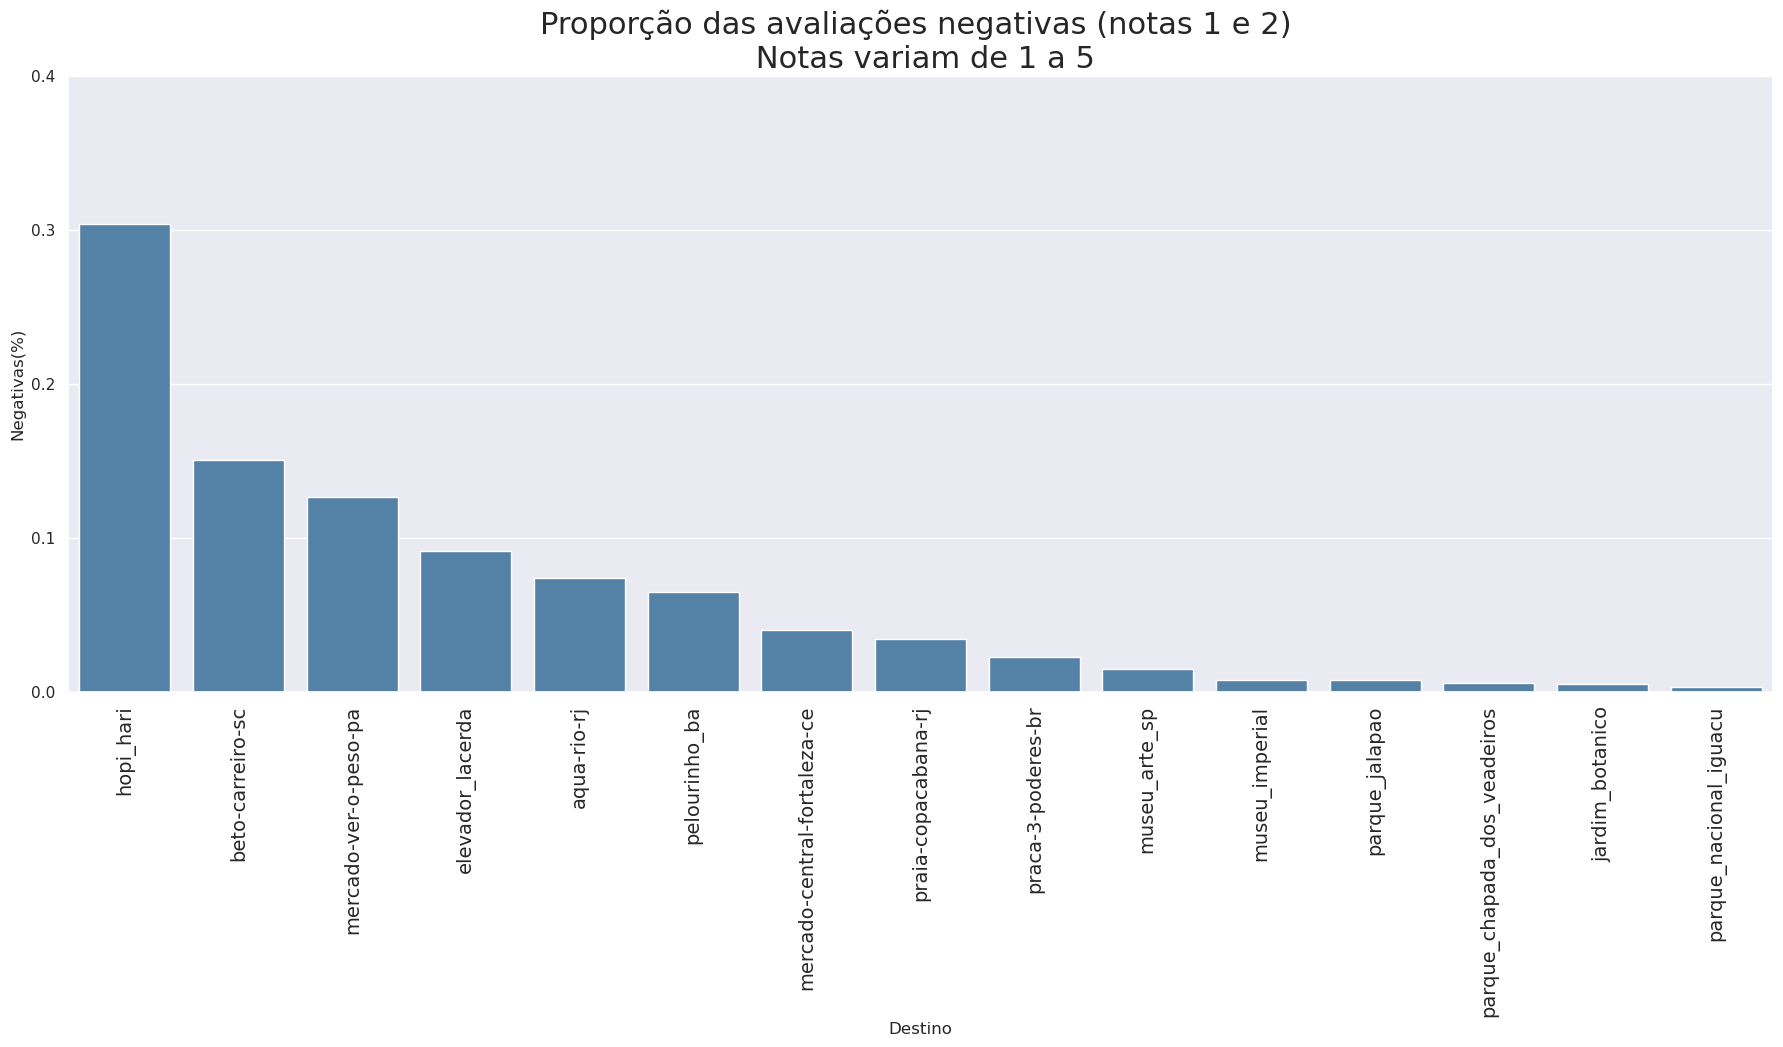

In [ ]:
# Criação de gráfico para comparação entre a proporção das avaliações negativas
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações negativas (notas 1 e 2) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Negativas(%)'],ascending=False,inplace=True),
              x=pos_neutra_neg.index,y=pos_neutra_neg['Negativas(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.5,0.1))
plt.xlabel('Destino')

In [ ]:
'''
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
row_subplot=0    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))

col_subplot=0
for atracao in nome_atracoes:
    notas_atracao=dados[atracao]
    notas_atracao=notas_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    notas_atracao.reset_index(inplace=True)
    ax=sns.barplot(notas_atracao,x='nota',y='Proporção de Avaliações',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, atracao)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao['Número_de_Avaliações'].sum()))
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])
'''

'\n#Plotar graficos com as proporções das avaliações para cada atração\nfig,axs=plt.subplots(8,2,figsize=(16,40))\nrow_subplot=0    #x=dados[nome_atracao].groupby(\'nota\').agg(Total=(\'nota\',\'count\'))\n\ncol_subplot=0\nfor atracao in nome_atracoes:\n    notas_atracao=dados[atracao]\n    notas_atracao=notas_atracao.groupby(\'nota\').agg(Número_de_Avaliações=(\'nota\',\'count\'))\n    notas_atracao[\'Proporção de Avaliações\']=notas_atracao[\'Número_de_Avaliações\']/notas_atracao[\'Número_de_Avaliações\'].sum()\n    notas_atracao.reset_index(inplace=True)\n    ax=sns.barplot(notas_atracao,x=\'nota\',y=\'Proporção de Avaliações\',ax=axs[row_subplot,col_subplot],color=\'steelblue\')\n    ax.text(-0.45, 0.95, atracao)\n    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao[\'Número_de_Avaliações\'].sum()))\n    ax.set_ylim(0,1)\n    row_subplot+=1\n    if row_subplot>7:\n        row_subplot=0\n        col_subplot=1\nfig.delaxes(axs[7][1])\n'

### Evolução anual da nota média de cada destino

In [ ]:
nomes_destinos

['parque_nacional_iguacu',
 'parque_chapada_dos_veadeiros',
 'museu_imperial',
 'mercado-central-fortaleza-ce',
 'jardim_botanico',
 'aqua-rio-rj',
 'mercado-ver-o-peso-pa',
 'praia-copacabana-rj',
 'elevador_lacerda',
 'pelourinho_ba',
 'museu_arte_sp',
 'praca-3-poderes-br',
 'parque_jalapao',
 'hopi_hari',
 'beto-carreiro-sc']

In [ ]:
#Criaçao de uma coluna com o ano que cada avaliação
for nome_destino in nomes_destinos:
    dados[nome_destino]['ano']=dados[nome_destino]['data'].apply(lambda x:x.split(' ')[-1])
    dados[nome_destino]=dados[nome_destino].astype({'ano':'int'})

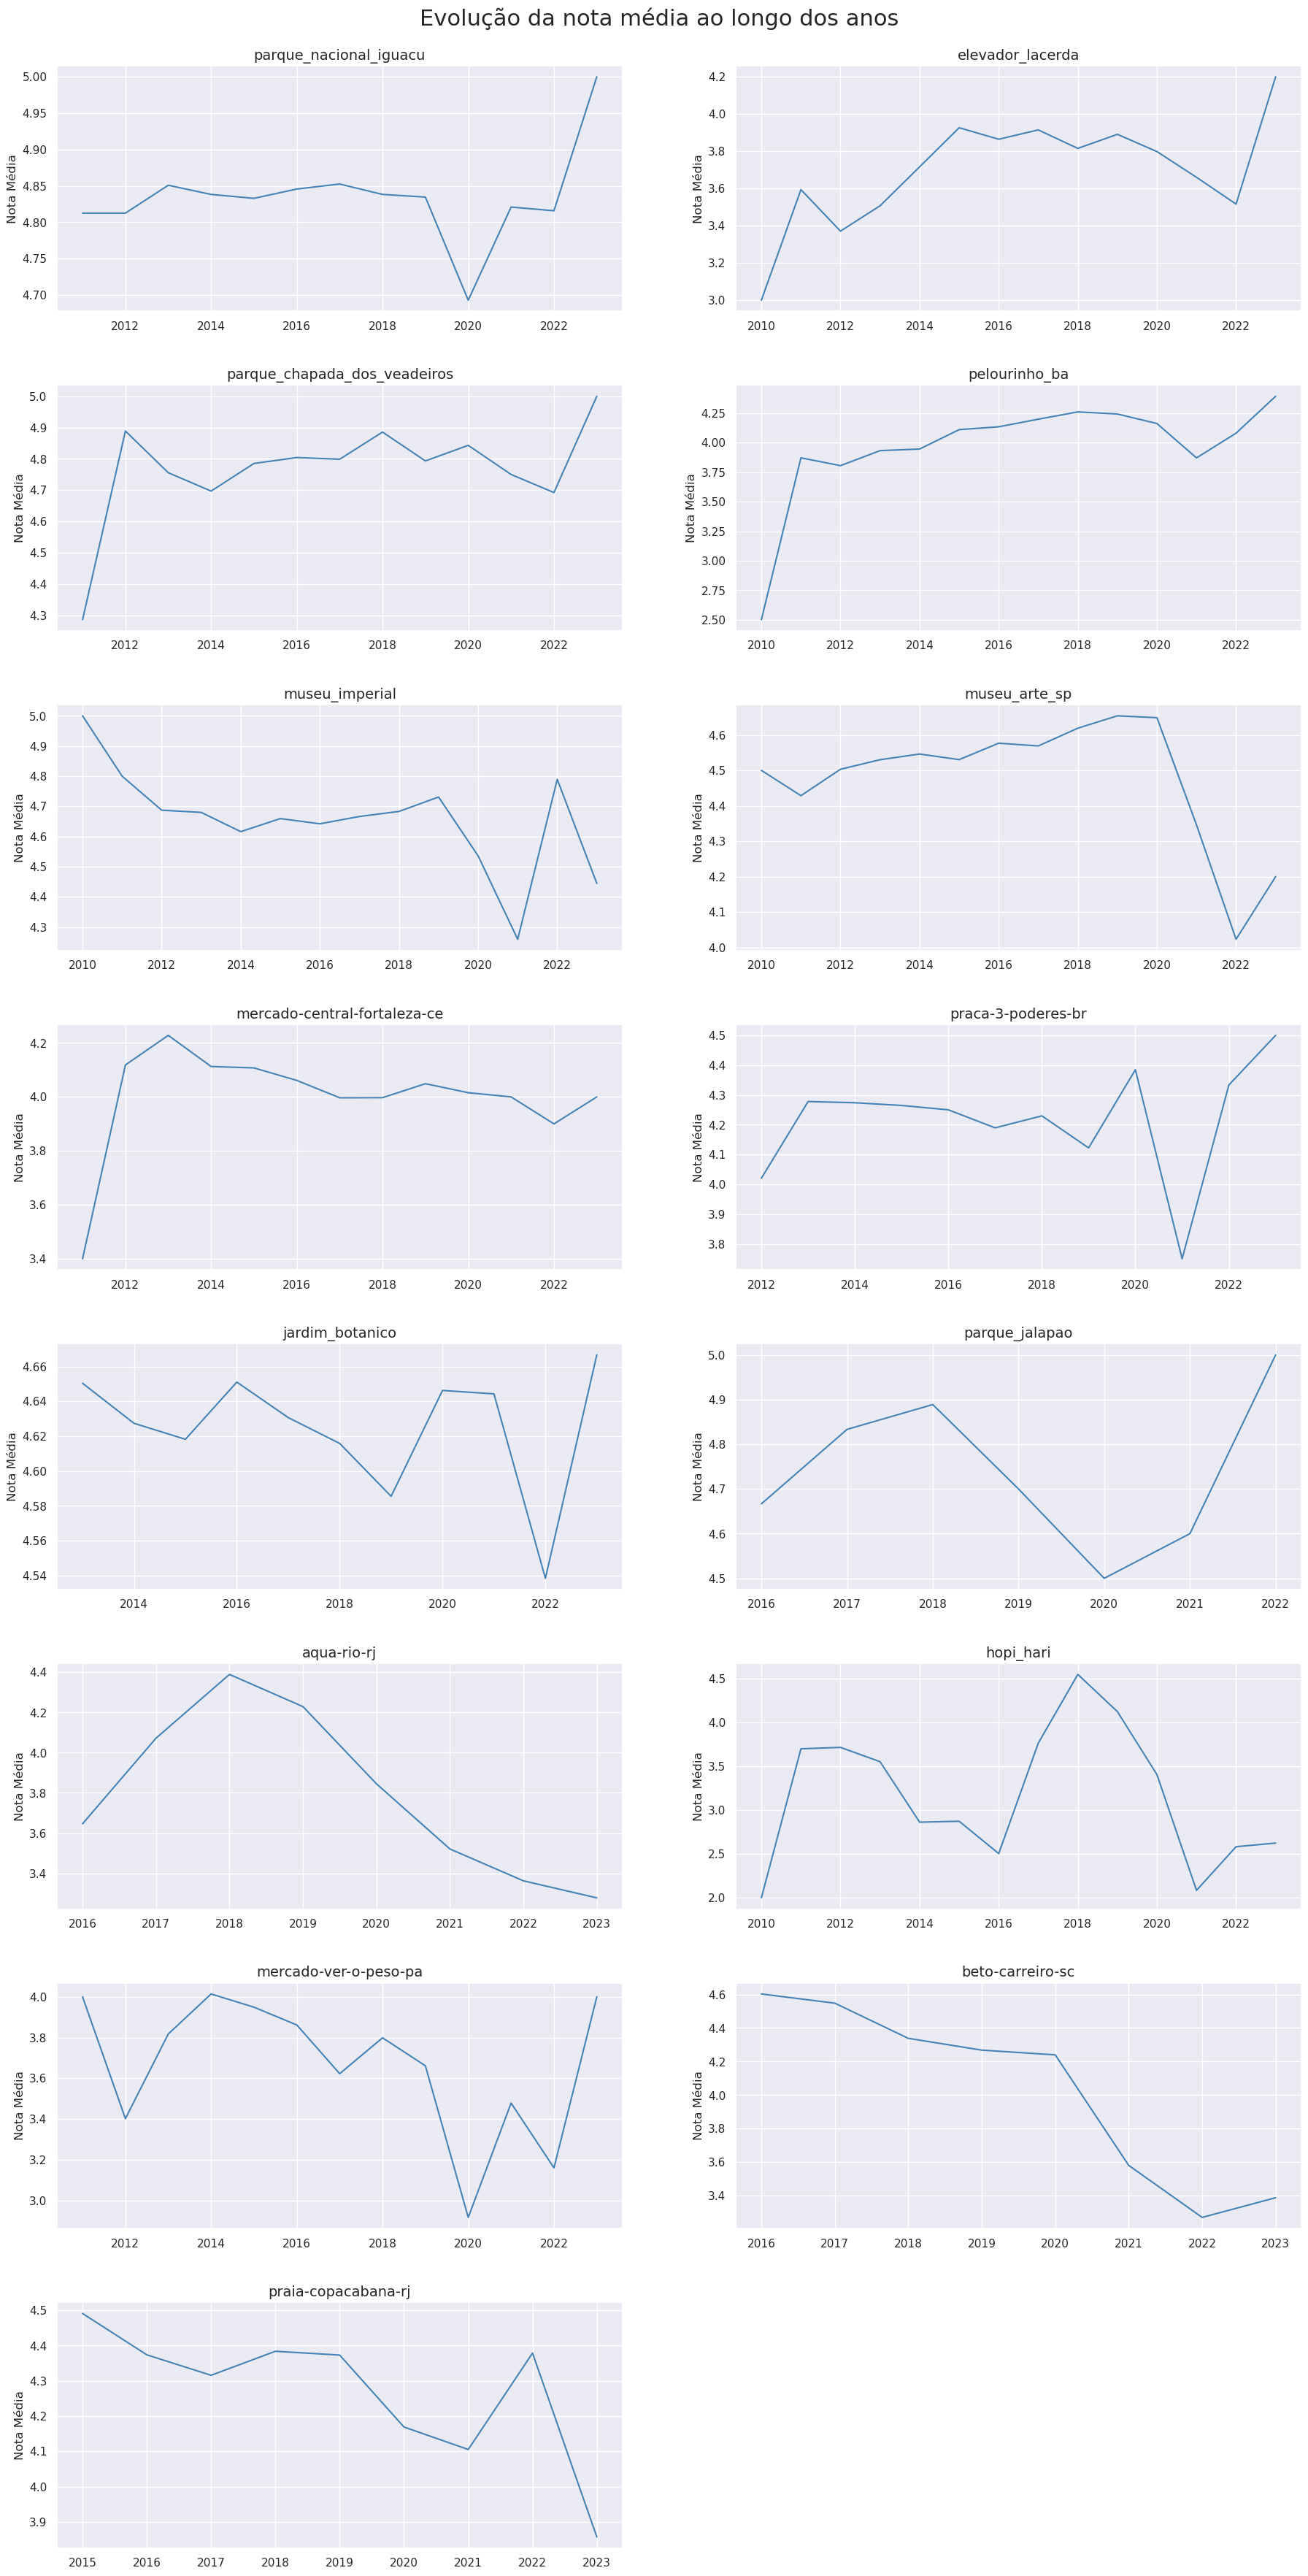

In [ ]:
#Plotar graficos com as proporções das avaliações para cada destino
fig,axs=plt.subplots(8,2,figsize=(22,40))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.subplots_adjust(top=0.96) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Evolução da nota média ao longo dos anos', fontsize=22) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
row_subplot=0
col_subplot=0
for nome_destino in dados.keys():
    destino_nota_media=dados[nome_destino].groupby('ano').agg(Nota_Media=('nota','mean'))
    destino_nota_media.reset_index(inplace=True)
    ax=sns.lineplot(destino_nota_media,x='ano',y='Nota_Media',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.set(ylabel='Nota Média')
    ax.set_title(nome_destino, fontsize=14)
    ax.set(xlabel=None)
    #ax.set_ylim(0,5)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1

fig.delaxes(axs[7][1])

# Análise Exploratória - Comentários

##  Dataset

In [ ]:
#Agrupar os dados de todos os destinos em um mesmo dataframe
for nome_destino in nomes_destinos:
    dados[nome_destino]['destino']=nome_destino
df_dados=pd.concat([dados[destino] for destino in nomes_destinos],axis=0)
df_dados.reset_index(inplace=True,drop=True)


In [ ]:
#Inputs do modelos são os comentários e outputs são as notas
df_x=df_dados[['comentario']].copy()
df_y=df_dados[['nota']].copy()
del df_dados

In [ ]:
#Dataset desbalanceado, são poucas avaliações com 1 ou 2 estrelas
df_y.value_counts()

nota
5.0     58040
4.0     26829
3.0     10902
2.0      2974
1.0      2400
dtype: int64

In [ ]:
#Aproximadamente 57% das avaliações receberam nota 5
df_y.value_counts()/len(df_y)

nota
5.0     0.573830
4.0     0.265253
3.0     0.107786
2.0     0.029403
1.0     0.023728
dtype: float64

In [ ]:
proporcao_notas_negativas=100*(df_y.value_counts()[3:].sum())/len(df_y)
print('Proporção das avaliações com notas 1 ou 2: {}%'.format(proporcao_notas_negativas))

Proporção das avaliações com notas 1 ou 2: 5.313164269118592%


In [ ]:
#O conjunto de dados será dividido em treino, validação e teste
#separacao treino, validação e teste
x_treino,x_val,y_treino,y_val    =train_test_split(df_x,df_y,test_size=0.2,stratify=df_y,random_state=42)
x_treino,x_teste,y_treino,y_teste=train_test_split(x_treino,y_treino,test_size=0.2,stratify=y_treino,random_state=42)


In [ ]:
#Aplicação de one hot encoding nas notas
encoder=OneHotEncoder(sparse=False)
y_treino_encoded=encoder.fit_transform(y_treino)
y_val_encoded   =encoder.fit_transform(y_val)
y_teste_encoded =encoder.fit_transform(y_teste)

In [ ]:
#A separação dos dados de treino e teste foi feito de modo estratificado, de modo que a propoção de amostras de cada classe foi mantida após a separação
proporcao_treino_teste=pd.concat((df_y.value_counts()/len(df_y),
                        y_treino.value_counts()/len(y_treino),
                        y_val.value_counts()/len(y_val),
                        y_teste.value_counts()/len(y_teste)),axis=1)
proporcao_treino_teste.columns=['Total','Treino','Validação','Teste']
proporcao_treino_teste

,Total,Treino,Validação,Teste
nota,,,,
5.0,0.573830,0.573827,0.573830,0.573838
4.0,0.265253,0.265247,0.265263,0.265262
3.0,0.107786,0.107798,0.107766,0.107761
2.0,0.029403,0.029398,0.029413,0.029412
1.0,0.023728,0.023729,0.023728,0.023727


In [ ]:
#Numero de amostras de cada nota nos dados de treino e teste
amostras_treino_teste=pd.concat((y_treino.value_counts(),y_val.value_counts(),y_teste.value_counts()),axis=1)
amostras_treino_teste.columns=['Treino','Validação','Teste']
amostras_treino_teste

,Treino,Validação,Teste
nota,,,
5.0,37145,11608,9287
4.0,17170,5366,4293
3.0,6978,2180,1744
2.0,1903,595,476
1.0,1536,480,384


In [ ]:
#Apagar dataframes quenão serão mais usados
del df_x,df_y


# Undersampling

Será necessário aplicar undersampling no dataset para igualar o número de amostras com cada nota.

In [ ]:
x_treino_undersampled,y_treino_undersampled=RandomUnderSampler(random_state=42).fit_resample(x_treino,y_treino)
y_treino_undersampled_encoded              =encoder.fit_transform(y_treino_undersampled)

In [ ]:
#Comparativo do número de amostras com cada nota antes e depois do undersampling
amostras_normal_undersampled=pd.concat((y_treino.value_counts(),y_treino_undersampled.value_counts()),axis=1)
amostras_normal_undersampled.columns=['Original','Undersampled']
amostras_normal_undersampled

,Original,Undersampled
nota,,
1.0,1536,1536
2.0,1903,1536
3.0,6978,1536
4.0,17170,1536
5.0,37145,1536


## Tamanho dos Comentários

O tamanho dos comentários pode ser avaliado tanto pelo número de palavras quanto pelo número de caracteres. Essa análise é importante porque alguns dos modelos que serão implementados necessitam receber inputs com o mesmo comprimento.

### Número de Palavras em cada Comentário

In [ ]:
tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
x_treino['tokens']     =x_treino['comentario'].apply(lambda x:x.lower())          #letras minúsculas
x_treino['tokens']     =x_treino['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação
x_treino['num_words']  =x_treino['tokens'].apply(lambda x:len(x))

In [ ]:
#75% dos comentários tem menos de 45 palavras (tokens)
x_treino.describe()

,num_words
count,64732.000000
mean,39.712383
std,37.094634
min,0.000000
25%,20.000000
50%,29.000000
75%,45.000000
max,1351.000000


<AxesSubplot:title={'center':'Número de palavras nos comentários'}, xlabel='num_words'>

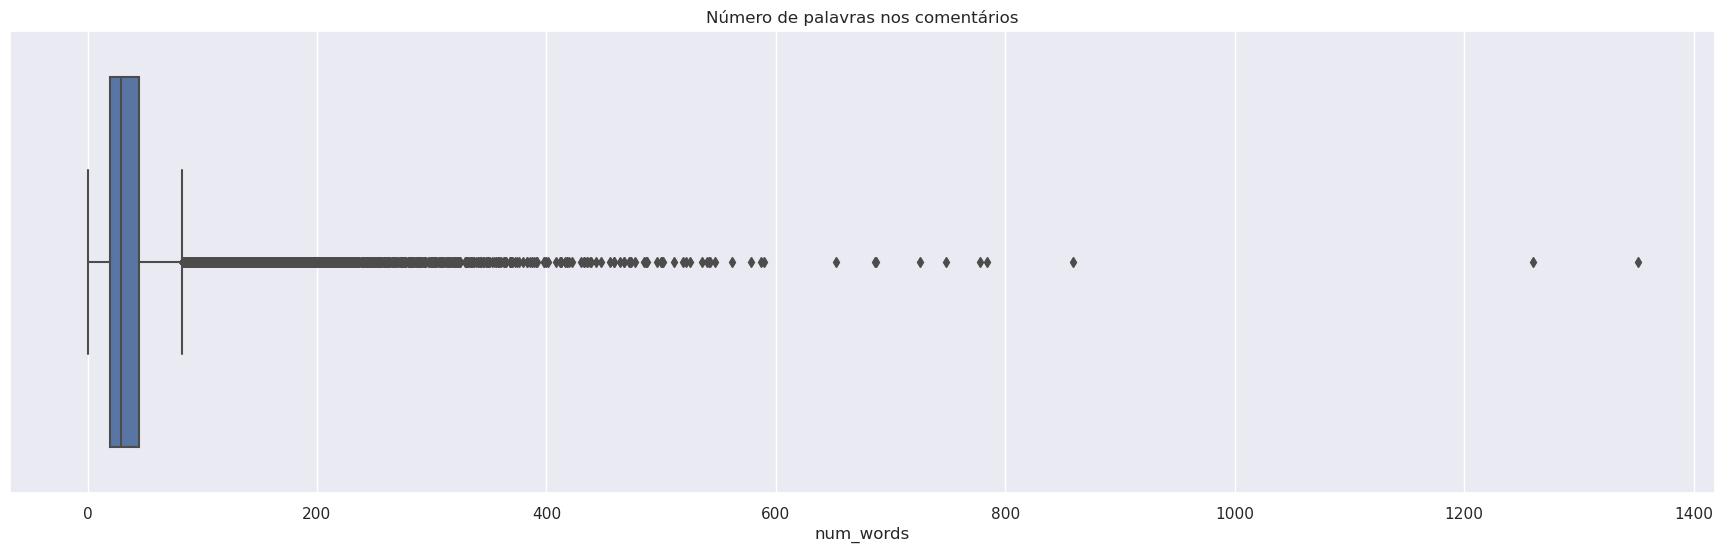

In [ ]:
#Número de palavras nos comentários:
#A grande maioria dos comentários tem pequeno número de palavras, 75% deles tem menos de 45 palavras.
#Nota-se a ocorrência de comentário sem nenhum token (provavelmente os caracteres do comentário não foram reconhecidos como token no processo de tokenização)
plt.figure(figsize=[22,6])
plt.title("Número de palavras nos comentários")
sns.boxplot(data=x_treino,x='num_words',orient='h')

In [ ]:
#Comentário com 0 tokens
#O comentário sem nenhum token foi escrito em outra lingua, com caracteres desconhecidos
x_treino[x_treino['num_words']==0]

,comentario,tokens,num_words
84326,"남미 최대의 미술관이라는 명성 처럼, 소장하고 있는 작품의 규모와 수준도 뛰어나지만...",[],0


Text(0.5, 12.44444444444443, 'Número de Palavras')

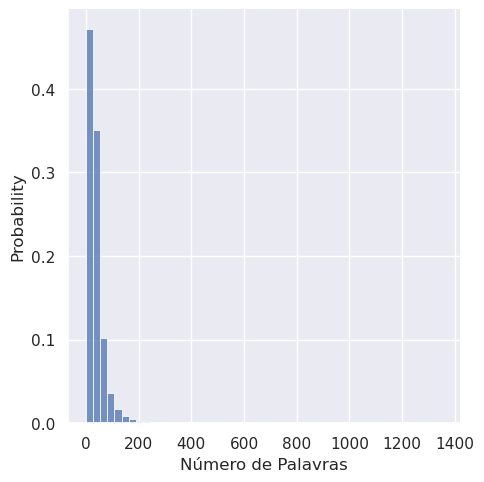

In [ ]:
#A grande maioria dos comentários tem pequeno número de palavras, poucos tem mais de 200.

sns.displot(data=x_treino,x='num_words',bins=50,stat='probability' )
plt.xlabel('Número de Palavras')


### Stopwords

Stopwords são palavras que aparecem comenmente em frases e que carregam pouca informação. Esse tipo de palavra é geralmente removido em análises de processamento de linguagem natural.

In [ ]:
#stopwords é uma lista com stopwords em lingua portuguesa
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [ ]:
#Calcular proporção de stopwords nos comentários
#Razão entre o número de stopwords e o número total de palavras em cada comentário
x_treino['freq_stopwords']=x_treino['tokens'].apply(lambda x:len([word for word in x if word in stopwords])/len(x) if len(x)>0 else 0)

Text(0.5, 0, 'Proporção de stopwords nos comentários')

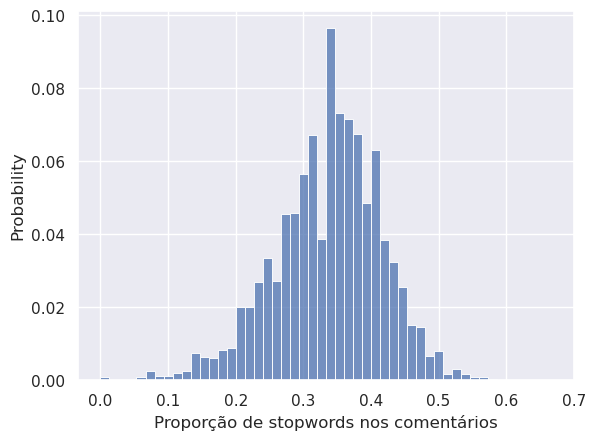

In [ ]:
#A maior parte dos comentários tem entre 30 a 40% das palavras compostas de stopwords
sns.histplot(data=x_treino,x='freq_stopwords',bins=50,stat='probability' )
plt.xlabel('Proporção de stopwords nos comentários')

In [ ]:
#Remoção de stopwords
x_treino['tokens_no_stowords']=x_treino['tokens'].apply(lambda x:[word for word in x if word not in stopwords])

In [ ]:
#Contagem do número de palavras em cada comentário após a remoção das stop words
x_treino['num_words_no_stopwords']  =x_treino['tokens_no_stowords'].apply(lambda x:len(x))

In [ ]:
#Antes da remoção das stopwords 75% dos comentários tinham menos de 45 palavras.
#Após a remoção das stopwords 75% dos comentários tem menos de 29 palavras.
x_treino.describe()


,num_words,freq_stopwords,num_words_no_stopwords
count,64732.000000,64732.000000,64732.000000
mean,39.712383,0.335613,25.799342
std,37.094634,0.079402,23.106555
min,0.000000,0.000000,0.000000
25%,20.000000,0.285714,14.000000
50%,29.000000,0.341463,19.000000
75%,45.000000,0.388889,29.000000
max,1351.000000,0.666667,824.000000


[Text(0.5, 1.0, 'Semom Stopwords')]

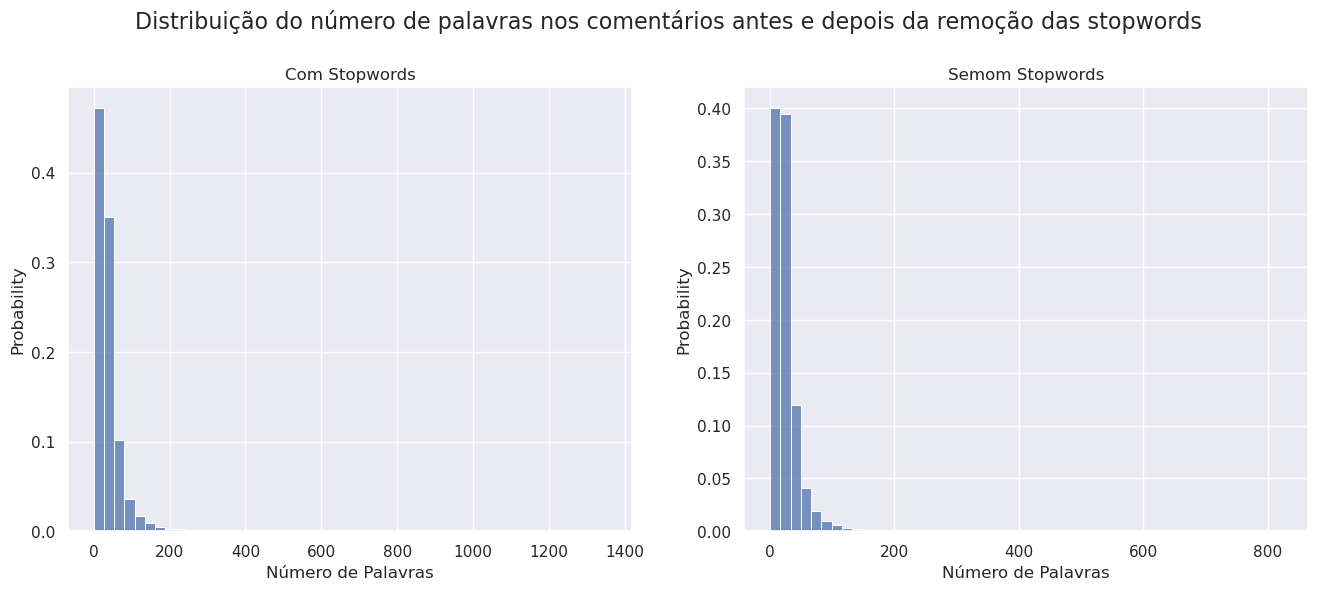

In [ ]:
#Distribuição do número de palavras nos comentários antes e depois da remoção das stopwords
fig, axes = plt.subplots(1, 2,figsize=(16,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.subplots_adjust(top=0.85) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Distribuição do número de palavras nos comentários antes e depois da remoção das stopwords', fontsize=16) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
sns.histplot(data=x_treino, x='num_words',bins=50,stat='probability', ax=axes[0])
sns.histplot(data=x_treino, x='num_words_no_stopwords',bins=50,stat='probability' ,ax=axes[1])
axes[0].set(xlabel='Número de Palavras')
axes[0].set(title='Com Stopwords')
axes[1].set(xlabel='Número de Palavras')
axes[1].set(title='Semom Stopwords')




In [ ]:
#Remover dos dados de treino as colunas criadas

x_treino=x_treino[['comentario']].copy()

# Pré-processamento dos comentários

Para o pré processamento dos comentários serão usadas duas bibliotecas,são elas NLTK e Spacy. As etapas de pré-processamento aplicadas com essas duas bibliotecas serão praticamente os mesmos com exceção da última. A última etapa do pré-processamento com NLTK será stemming, enquando no caso da Spacy será lemmantization. Isso porque o NLTK não conta com o recurso de lemmantization em ligua portuguesa enquanto o Spacy não conta com stemming para o português.

- STEMMING: consiste em reduzir a palavra ao seu radical.
  Por exemplo as palavras amigo, amiga e amigão seriam todas reduzidas ao radical amig.

- LEMATIZAÇÃO: consiste em reduzir a palavra àsua forma canônica, levando em conta sua classe gramatical.
  Por exemplo  as palavras propõem, propuseram e propondo serias todas transformarmadas em propor.

## Pré-processamento com NLTK

- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Remover acentos e substituir cedillha;
- Stemming.

In [ ]:
def preprocess_nltk(dados,remover_acentos=False,coluna='comentario'):
    '''
    Funação recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Remoção pontuação
        -Remoção de stop words;
        -Opcional: remover acentuação e substituir cedilha (caracteres presentes na lingua portuguesa)


    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários;

    Output:
        -Dataframe com uma única coluna contendo os tokens pré-processados
    '''
    tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
    stopwords = nltk.corpus.stopwords.words('portuguese') #lista de stopwords na lingua portuguesa
    dados=dados.copy()
    dados['tokens']     =dados[coluna].apply(lambda x:x.lower())          #letras minúsculas
    dados['tokens']     =dados['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação
    dados['tokens']     =dados['tokens'].apply(lambda x:[word for word in x if word not in stopwords]) #remover stop words
    dados.drop(coluna,axis=1,inplace=True)
    return dados

In [ ]:
#Função que aplica stemming
def stemmming_nltk(dados,coluna='tokens'):
    '''
    Função que aplica stemming na coluna especificada

    Inputs:
        -Dataframe com coluna contendo lista com tokens

    Outputs:
        -Dataframe original com stemming aplicado nos tokens
    '''
    stemmer=nltk.RSLPStemmer()
    dados[coluna]=dados[coluna].apply(lambda x:[stemmer.stem(word) for word in x]) #stemming nos tokens
    return dados

## Pré-processamento com Spacy

- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Lemmantization.

In [ ]:
def lemmantizar(dados,remover_acentos=False,coluna='comentario'):
    '''
    Função recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Somente palavras nos comentários (remoção de pontuação, números, etc)
        -Remoção de stop words;
        -lemmantization;

    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários;

    Output:
        -Dataframe com uma única coluna contendo em cada linha uma lista de tokens pré-processados
    '''
    dados=dados.copy()
    nlp=spacy.load("pt_core_news_lg")
    dados['tokens']=dados[coluna].apply(lambda x:x.lower()) #letras minúsuculas
    dados['tokens']=dados['tokens'].apply(lambda x: [token.lemma_ for token in nlp(x) if token.is_alpha and not token.is_stop]) #manutenção somente de palavras nos tokens
                                                                                                                                #e remoção de stopwords
    dados.drop(coluna,axis=1,inplace=True) #mantém somente a coluna com os tokens criados
    return dados

### Pipelines de pré-processamento


Serão criadas pipeline de pré-processamento dos comentários que contarão com as seguites etapas:

- Pré-processamento com biblioteca NLTK ou Spacy;
- Opcional: remoção de acentuação e substituição de cedilha;
- Padroninação do número de palavras nos comentários.
- Undersampling nos dados de treino para igualar o número de amostras com cada nota.

Datasets:

- x_treino, y_treino_encoded
- x_treino_undersampled , y_treino_undersampled_encoded
- x_val   , y_val_encoded
- x_teste , y_teste_encoded


In [ ]:
def acentos_cedilha(dados, coluna='tokens'):
    '''
    Função para remover acentuação e substituir a cedilha pela letra c
    '''
    dados[coluna]=dados[coluna].apply(lambda x:[normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII') for word in x])


In [ ]:
def padronizar_num_tokens(dados,num_words=25,coluna='tokens'):
    '''
    Função para padranizar o número de palavras nos comentários.
    Comentários com número de palavras maior que o especificado serão truncados, enquanto aos com número maior será aplicado padding

    inputs-
    dados     - dataframe com coluna contendo os tokens dos comentátios
    coluna    - coluna com tokens
    max_words - número máximo de palavras em cada comentário

    outputs-
    Dataframe com todos os comentários com mesmo número de tokens;
    Cada comentário no formato [1,num_words]
    '''
    dados[coluna]=dados[coluna].apply(lambda x: [x[:num_words]if len(x)>num_words else x+(num_words-len(x))*['pad']])
    dados[coluna]=dados[coluna].apply(lambda x:np.array(x).reshape([1,-1]))
    dados=np.array(dados[coluna])
    dados=np.concatenate(dados,axis=0)
    return dados

In [ ]:
# Pipeline com NLTK
'''
pipeline_treino_NLTK=make_pipeline(
            FunctionTransformer(preprocess_nltk),
            FunctionTransformer(stemmming_nltk),
            FunctionTransformer(padronizar_num_tokens),
            undersampler)
'''

pipeline_NLTK=make_pipeline(
            FunctionTransformer(preprocess_nltk),
            FunctionTransformer(stemmming_nltk),
            FunctionTransformer(padronizar_num_tokens))

In [ ]:
# Pipeline com Spacy
'''
pipeline_treino_Spacy=make_pipeline(
            FunctionTransformer(lemmantizar),
            FunctionTransformer(padronizar_num_tokens),
            undersampler)
'''

pipeline_Spacy=make_pipeline(
            FunctionTransformer(lemmantizar),
            FunctionTransformer(padronizar_num_tokens))

In [ ]:
#x_treino_lemann_undersampled=pipeline_Spacy.fit_transform(x_treino_undersampled)
x_val_lemman  =pipeline_Spacy.fit_transform(x_val)
x_teste_lemamn=pipeline_Spacy.fit_transform(x_teste)

In [ ]:
#x_treino_lemman=pipeline_Spacy.fit_transform(x_treino)
x_treino_lemman=np.load('../x_treino_lemman.npy')

## Análise da frequência que cada palavra aparece nos comentários com cada nota

In [ ]:
#Contar o número de vezes que cada palavra aparece nos comentários com a mesma nota e também o número total de vezes que cada palavra aparece
nota1_count=Counter()
nota2_count=Counter()
nota3_count=Counter()
nota4_count=Counter()
nota5_count=Counter()
total=Counter()

In [ ]:
#Selecionar os dados que serão usados para a contagem das palavras
#Para comparação será usado o dataset undersampled
#Pode ser usados os dados com lemmantização ou os dados com stemming
x_dataset=x_treino_lemann_undersampled
y_dataset=np.array(y_treino_undersampled)

In [ ]:
#varrer todos os comentário fazendo a contagem do número de vezes que as palavras aparecem
for num_row in range(len(x_dataset)):
    if y_dataset[num_row]==1:
        nota1_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==2:
        nota2_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==3:
        nota3_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==4:
        nota4_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==5:
        nota5_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

In [ ]:
#Palavras mais comuns nos comentários com nota 1
nota1_count.most_common()

[('pad', 6932),
 ('parque', 924),
 ('fila', 827),
 ('brinquedo', 697),
 ('dia', 362),
 ('hora', 330),
 ('pessoa', 265),
 ('atração', 260),
 ('pra', 244),
 ('ficar', 230),
 ('ingresso', 219),
 ('ter', 201),
 ('haver', 190),
 ('conseguir', 188),
 ('comprar', 173),
 ('ser', 164),
 ('péssimo', 160),
 ('entrar', 158),
 ('estar', 155),
 ('fechar', 152),
 ('funcionar', 150),
 ('chegar', 148),
 ('muito', 147),
 ('experiência', 143),
 ('criança', 138),
 ('elevador', 136),
 ('estacionamento', 134),
 ('pagar', 133),
 ('passar', 132),
 ('caro', 129),
 ('sujo', 128),
 ('ano', 127),
 ('preço', 114),
 ('ir', 113),
 ('entrada', 109),
 ('horrível', 108),
 ('andar', 107),
 ('recomendar', 106),
 ('lotar', 103),
 ('valer', 103),
 ('gente', 98),
 ('voltar', 98),
 ('pena', 98),
 ('absurdo', 97),
 ('funcionário', 92),
 ('manutenção', 92),
 ('montanha', 92),
 ('hari', 92),
 ('bom', 90),
 ('turista', 89),
 ('cuidado', 87),
 ('cidade', 86),
 ('achar', 84),
 ('conhecer', 83),
 ('visitar', 83),
 ('ver', 83),
 ('r

In [ ]:
#Palavras mais comuns nos comentários com nota 5

nota5_count.most_common()

[('pad', 14549),
 ('parque', 402),
 ('passeio', 296),
 ('valer', 292),
 ('lindo', 260),
 ('pena', 245),
 ('jardim', 222),
 ('conhecer', 208),
 ('dia', 200),
 ('visitar', 191),
 ('bom', 188),
 ('cuidado', 181),
 ('muito', 161),
 ('maravilhoso', 160),
 ('cidade', 157),
 ('museu', 144),
 ('bonito', 140),
 ('natureza', 139),
 ('ficar', 130),
 ('visita', 129),
 ('história', 127),
 ('curitiba', 126),
 ('lir', 125),
 ('foto', 115),
 ('limpo', 110),
 ('pra', 109),
 ('excelente', 106),
 ('praia', 105),
 ('gostar', 100),
 ('organizar', 98),
 ('atração', 97),
 ('botânico', 97),
 ('levar', 95),
 ('passar', 95),
 ('beleza', 94),
 ('deixar', 88),
 ('haver', 87),
 ('trilha', 86),
 ('criança', 86),
 ('família', 84),
 ('passear', 81),
 ('recomendar', 80),
 ('incrível', 80),
 ('catarata', 79),
 ('super', 78),
 ('pelourinho', 77),
 ('Brasil', 77),
 ('tirar', 73),
 ('preço', 72),
 ('turístico', 71),
 ('estrutura', 71),
 ('brinquedo', 70),
 ('entrada', 70),
 ('pessoa', 69),
 ('belo', 69),
 ('exposição', 66

In [ ]:
#Palavras mais comuns nos comentários com nota 2
nota2_count.most_common()

[('pad', 8917),
 ('parque', 573),
 ('fila', 436),
 ('brinquedo', 406),
 ('atração', 288),
 ('ficar', 242),
 ('elevador', 232),
 ('dia', 231),
 ('muito', 223),
 ('pessoa', 220),
 ('haver', 179),
 ('ter', 169),
 ('pra', 167),
 ('valer', 164),
 ('sujo', 164),
 ('ser', 160),
 ('mercado', 159),
 ('achar', 158),
 ('pena', 158),
 ('hora', 156),
 ('bom', 149),
 ('preço', 143),
 ('cuidado', 138),
 ('cidade', 137),
 ('estar', 136),
 ('fechar', 134),
 ('caro', 130),
 ('ingresso', 129),
 ('bonito', 129),
 ('praia', 124),
 ('conseguir', 121),
 ('visitar', 121),
 ('conhecer', 117),
 ('chegar', 115),
 ('vista', 113),
 ('comprar', 111),
 ('deixar', 109),
 ('turista', 109),
 ('ver', 107),
 ('esperar', 107),
 ('pagar', 106),
 ('estacionamento', 103),
 ('cheio', 102),
 ('funcionar', 101),
 ('pouco', 100),
 ('criança', 97),
 ('visita', 92),
 ('gente', 92),
 ('entrar', 92),
 ('ano', 92),
 ('manutenção', 91),
 ('pelourinho', 90),
 ('alto', 87),
 ('pequeno', 86),
 ('passar', 85),
 ('passeio', 82),
 ('rua', 8

In [ ]:
#Palavras menos comuns nos comentários com nota 5
nota5_count.most_common()[-1:-20:-1]

[('compativel', 1),
 ('trager', 1),
 ('free', 1),
 ('carioquinha', 1),
 ('amal', 1),
 ('abril', 1),
 ('urbanizar', 1),
 ('m', 1),
 ('banhar', 1),
 ('deparar', 1),
 ('cheira', 1),
 ('muitíssimo', 1),
 ('desculpa', 1),
 ('requintado', 1),
 ('inacreditaval', 1),
 ('memorável', 1),
 ('capacidade', 1),
 ('antecedência', 1),
 ('dimensao', 1)]

In [ ]:
#Palavras menos comuns nos comentários com nota 1
nota1_count.most_common()[-1:-20:-1]

[('bisavós', 1),
 ('comemoração', 1),
 ('timbó', 1),
 ('Joinville', 1),
 ('reclamaqui', 1),
 ('farei', 1),
 ('mundi', 1),
 ('giranda', 1),
 ('katapul', 1),
 ('eléktron', 1),
 ('chabum', 1),
 ('Tokaia', 1),
 ('lotadoooo', 1),
 ('coerente', 1),
 ('parceiro', 1),
 ('condizr', 1),
 ('imperial', 1),
 ('petrópolis', 1),
 ('nervosismo', 1)]

Entre as palavras mais comuns nos comemtários com nota 5 aparecem algumas com conotação extremamente positiva, como maravilhoso e excelente. Enquanto nos comentários com nota 1 já aparecem palavras com conotação negativa, como péssimo e sujo por exemplo

Já verificando as palavras que aparecem com menor frequência, verifica-se a ocorrência de palavras incomuns, com grafia errada e com erros de digitação. Palavras que aparecem raramente não podem ser empregadas para caracterizar um conjunto de comentários.



Para facilitar a comparação das palavras que aparecem com maior frequência em cada nota, será calculada a razão entre o número de vezes que cada palavra aparece em comentários com certa nota e o número de vezes em que a palavra apareceu em todos os comentários. Por exemplo, caso a palavra excelente apareça somente em comentários com nota 5, a razão para essa palavra será 1 para nota 5 e 0 para os demais. Ou seja, palavram que apareçam com maior frequência em comentários com certa nota terão razao mais próximas de 1.



In [ ]:
#Palavras raras serão desconsideradas no cálculo das razões
def calcular_razao(counter_nota,counter_total,min_freq):
    '''
    Função para calcular a razão entre o numero de vezes que a palavra aparece em comentários com certa nota e o nḿero de vezes que a palavra aparece em
    todos os comentários

    inputs:
    counter_nota  - objeto Counter com número de vezes que as palavras aparerem em comentários com certa nota
    counter_total - objeto Counter com número de vezes que as palavras aparerem no conjunto de todos os comentrários
    min_freq      - número mínimo de vezes que uma palavra deve aparecer para ser consideradas. Palavras raras não são úteis para caracterizar os comentários
    '''
    razao=Counter()
    for palavra in counter_nota:
        if counter_nota[palavra]>min_freq:
            razao[palavra]=counter_nota[palavra]/counter_total[palavra]
    return razao


min_freq=100 #Palavra deve ter aparecido no mínimo cem vezes para ser considerada

razao_nota5=calcular_razao(nota5_count,total,min_freq)
razao_nota4=calcular_razao(nota4_count,total,min_freq)
razao_nota3=calcular_razao(nota3_count,total,min_freq)
razao_nota2=calcular_razao(nota2_count,total,min_freq)
razao_nota1=calcular_razao(nota1_count,total,min_freq)

In [ ]:
razao_nota5.most_common()

[('natureza', 0.6650717703349283),
 ('curitiba', 0.5454545454545454),
 ('maravilhoso', 0.5298013245033113),
 ('lindo', 0.4537521815008726),
 ('excelente', 0.4491525423728814),
 ('lir', 0.43859649122807015),
 ('jardim', 0.4228571428571429),
 ('limpo', 0.40145985401459855),
 ('passeio', 0.37659033078880405),
 ('museu', 0.31718061674008813),
 ('história', 0.297423887587822),
 ('pad', 0.263473379210431),
 ('pena', 0.2598091198303287),
 ('valer', 0.2581786030061892),
 ('visitar', 0.25603217158176944),
 ('conhecer', 0.2503008423586041),
 ('cuidado', 0.24262734584450402),
 ('visita', 0.2275132275132275),
 ('bom', 0.22488038277511962),
 ('foto', 0.2237354085603113),
 ('cidade', 0.20284237726098192),
 ('bonito', 0.1907356948228883),
 ('praia', 0.1855123674911661),
 ('dia', 0.17953321364452424),
 ('muito', 0.1718249733191035),
 ('parque', 0.16288492706645058),
 ('ficar', 0.1326530612244898),
 ('pra', 0.13132530120481928)]

In [ ]:
razao_nota3.most_common()

[('elevador', 0.35705045278137126),
 ('alto', 0.3493975903614458),
 ('vista', 0.345679012345679),
 ('legal', 0.33554817275747506),
 ('achar', 0.3226890756302521),
 ('bonito', 0.3119891008174387),
 ('cidade', 0.31136950904392763),
 ('mercado', 0.30697674418604654),
 ('interessante', 0.30238726790450926),
 ('pelourinho', 0.2768361581920904),
 ('tirar', 0.26735218508997427),
 ('praia', 0.2667844522968198),
 ('foto', 0.26459143968871596),
 ('gostar', 0.2388758782201405),
 ('preço', 0.23865546218487396),
 ('turista', 0.23776223776223776),
 ('valer', 0.2369584438549956),
 ('cuidado', 0.2359249329758713),
 ('conhecer', 0.23345367027677497),
 ('visita', 0.2275132275132275),
 ('muito', 0.22625400213447172),
 ('bom', 0.2236842105263158),
 ('pad', 0.21519377037305323),
 ('pra', 0.20963855421686747),
 ('ficar', 0.20408163265306123),
 ('pessoa', 0.20365853658536584),
 ('ser', 0.2020033388981636),
 ('pena', 0.19936373276776245),
 ('haver', 0.19074333800841514),
 ('ter', 0.18699186991869918),
 ('pass

In [ ]:
razao_nota2.most_common()

[('sujo', 0.43271767810026385),
 ('fechar', 0.3743016759776536),
 ('esperar', 0.36271186440677966),
 ('caro', 0.3448275862068966),
 ('funcionar', 0.3126934984520124),
 ('atração', 0.3116883116883117),
 ('pagar', 0.30994152046783624),
 ('elevador', 0.3001293661060802),
 ('conseguir', 0.28741092636579574),
 ('brinquedo', 0.28551336146272854),
 ('estar', 0.28451882845188287),
 ('fila', 0.2780612244897959),
 ('ver', 0.2772020725388601),
 ('ter', 0.27479674796747966),
 ('ingresso', 0.2721518987341772),
 ('cheio', 0.26842105263157895),
 ('pessoa', 0.2682926829268293),
 ('ser', 0.2671118530884808),
 ('achar', 0.26554621848739496),
 ('estacionamento', 0.2654639175257732),
 ('chegar', 0.26376146788990823),
 ('turista', 0.2540792540792541),
 ('haver', 0.25105189340813466),
 ('ficar', 0.24693877551020407),
 ('mercado', 0.24651162790697675),
 ('deixar', 0.24439461883408073),
 ('hora', 0.24036979969183359),
 ('preço', 0.24033613445378152),
 ('muito', 0.23799359658484526),
 ('vista', 0.2325102880658

In [ ]:
razao_nota1.most_common()

[('horrível', 0.7552447552447552),
 ('péssimo', 0.7111111111111111),
 ('fila', 0.5274234693877551),
 ('hora', 0.5084745762711864),
 ('lotar', 0.5073891625615764),
 ('experiência', 0.49140893470790376),
 ('brinquedo', 0.490154711673699),
 ('funcionar', 0.46439628482972134),
 ('ingresso', 0.4620253164556962),
 ('conseguir', 0.44655581947743467),
 ('entrar', 0.4438202247191011),
 ('fechar', 0.4245810055865922),
 ('pagar', 0.3888888888888889),
 ('parque', 0.37439222042139386),
 ('estacionamento', 0.34536082474226804),
 ('ano', 0.3423180592991914),
 ('caro', 0.3421750663129973),
 ('chegar', 0.3394495412844037),
 ('sujo', 0.33773087071240104),
 ('comprar', 0.3288973384030418),
 ('ter', 0.32682926829268294),
 ('dia', 0.3249551166965889),
 ('estar', 0.32426778242677823),
 ('pessoa', 0.3231707317073171),
 ('ir', 0.3210227272727273),
 ('recomendar', 0.3081395348837209),
 ('entrada', 0.3061797752808989),
 ('pra', 0.29397590361445786),
 ('criança', 0.28336755646817247),
 ('passar', 0.2814498933901

Analisando as palavras com maior razão nos comentários com nota 5,ou seja, aquelas palavras que aparecem proporcionalmente com maior frequência nos comentários com nota 5, estão palavras com conotação positiva como lindo maravilhoso e excelente.Por exemplo, em 53% dos comentários onde a palavra maravilhoso apareceu a nota do comentário era 5.Já para os comentários com nota 1, encontramos palavras de conotação negativa como horrível, péssimo, filas, etc.Por exemplo, em 75% dos comentários que em que a palavra horrível apareceu a nota do comentário era 1.Lembrando que as palavras incomuns foram excluídas do cáculo da razão.

In [ ]:
#Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
def numero_ocorrencias(palavra):
    '''
    Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
    A contagem será feita no conjunto de dados com mesmo número amostras de cada comentário para possibilitar a comparação

    Input
    palavra (palavra) - A palavra para a qual se deseja exibir a contagem
    '''
    print('Número de vezes que a palavra {} apareceu nos comentários: '.format(palavra))
    print('')
    print('Nota 5: {}'.format(nota5_count[palavra]))
    print('Nota 4: {}'.format(nota5_count[palavra]))
    print('Nota 3: {}'.format(nota3_count[palavra]))
    print('Nota 2: {}'.format(nota2_count[palavra]))
    print('Nota 1: {}'.format(nota1_count[palavra]))


In [ ]:
#Exibindo o número de ocorrências da palavra maravilhoso nos comentários com cada nota
#Interessante notar que a palavra maravilhoso aparece am alguns comentários com notas ruins
numero_ocorrencias('maravilhoso')

Número de vezes que a palavra maravilhoso apareceu nos comentários: 

Nota 5: 160
Nota 4: 160
Nota 3: 41
Nota 2: 18
Nota 1: 16


In [ ]:
#Exibindo o número de ocorrências da palavra péssimo nos comentários com cada nota
numero_ocorrencias('pessimo')

Número de vezes que a palavra pessimo apareceu nos comentários: 

Nota 5: 0
Nota 4: 0
Nota 3: 0
Nota 2: 3
Nota 1: 12


In [ ]:
#Vamos verificar exemplos de comentarios com as notas e palavras selecionadas
nota_selecionada=1
palavra_selecionada='maravilhoso'
exemplos=[]
for row_comentario in range(len(y_dataset)):
    if ((y_dataset[row_comentario]==nota_selecionada) and (palavra_selecionada in x_dataset[row_comentario])):
        exemplos+=[x_treino_undersampled.iloc[row_comentario,0]]


In [ ]:
#Exemplode comentário com nota 1 onde aparece a palavra maravilhoso
exemplos[0]

'Estive em 18/07 no AquaRio, com marido e 2 filhos. Já estive no maravilhoso Aquário de São Paulo e vim já sabendo que o AquaRio não se compara a ela, mas não imaginava que a distância fosse tão colossal.Os preços são absurdos para o que se oferece. Pagamos 38,00 de estacionamento e 240,00 de ingressos (80 por adulto e 40 para cada criança entre 3 e 11 anos). Ao chegarmos, havia 3 filas gigantescas: uma para comprar ingressos com dinheiro, outra com cartão e outra que teoricamente deveria ser a fila das pessoas que já tinham ingressos. Compramos os ingressos pelo celular para enfrentar uma fila a menos e fomos para a fila de entrada. Muita desorganização, funcionários despreparados e mal educados, que não sabiam organizar as filas nem tinham boa vontade para tirar dúvidas. O dia estava muito frio, chuviscando, e eles pareciam não se importar com as dezenas de famílias que tentavam obter informações sobre onde comprar ingresso e onde entrar.Depois de muito tempo, conseguimos entrar. Que

Os resultados encontrados indicam que a frequência de aparição de palavras em comentários com diferentes notas pode ser usado para identificar
a nota relativa a cada comentário. Ou seja, determinadas palavras aparecem somente em comentários com certas notas.

# Rede Neural Multi Layer Perceptron


Nessa seção será criada uma rede neural que  a presença ou não de certas palavras em um comentário para lhe atribuir uma nota. A rede será para classificação e vai receber como input um comentário e gerará como saída umas das cinco notas possíveis.
Conforme verificado no tópico anterior, certas palavras aparecem com maior frequência em comentários com determinada nota. Para selecionar as palavras que serão usadas para caracterizar os comentários será usada a razão entre o número de vezes que a palavra apareceu em comentários com certa notas e o número total de vezes que a palavra apareceu em todos os comentários. Será escolhido um threshold, onde somente as palavras com razão acima desse valor serão usadas pela rede. Lembrando que uma palavra que aparece em todo tipo de comentário tem razão aproximandamente igual a 0.2.

Será criado um vocabulário que conterá todas as palavras que serão usadas para classificar a nota de um comentário. Esse vocabulário será um dicionário em que as chaves serão as palavras selecionadas e os valores serão números que servirão como identificador para cada palavra. As palavras selecionadas para fazer parte do vocabulário serão aquelas em que a razão entre o número de aparições em comentários com certa nota e o número total de aparições supera o threshold especificado.

## Preparação dos dados para a rede MLP

In [ ]:
#Criação de um vocabuário
'''
O vocabulário conterá todas as palavras que serão usadas para classificar a nota de um comentário. É um dicionário em que as chaves são as
palavras selecionadas e os valores são números que servirão como identificador para cada palavra. As palavras selecionadas para fazer parte
do vocabulário são aquelas em que a razão entre o número de aparições em comentários com certa nota e o número total de aparições supera
certo threshold especificado.
'''

threshold=0.25
vocab_MLP={}
razoes=[razao_nota1,
        razao_nota2,
        razao_nota3,
        razao_nota4,
        razao_nota5]
num=0
for razao_nota in razoes:
    for palavra,razao in razao_nota.most_common():
        if razao>=threshold and palavra not in vocab_MLP.keys():
            vocab_MLP[palavra]=1



As entradas da rede neural serão os comentários. Porém as palavras desses cometários deverão ser transformadas em valores numéricos para que possam ser usados pela rede neural. Cada comentário será convertido em um vetor [1,n_palavras] onde n_palavras é o número total de palavras presente no vocabulário criado. Esse vetor terá 0s para indicar que a palavra não está presente no comentário e 1s caso contrário. As posições no vetor que receberão os valores 1 serão os valores das palavras no vocabulário criado. Por exemplo, imagine que a palavra horrivel receba o valor 10 no vocabulário. Caso a palavra horrivel esteja no comentário, o index 10 do vetor receberá o valor 1.

In [ ]:
def converter_comentarios(comentarios, vocab):
    '''
    Função que transforma os comentários em entradas numéricas para a rede neural

    inputs :

    comentarios - dataframe com os comentários
    vocab       - dicionário com o vacabulário criado, nop qual as palavras são as chaves e os valores um indicador para cada palavra
    '''

    x_numerico=np.zeros([len(comentarios),len(vocab)])
    for row_comentario in range(len(comentarios)):
        for word in comentarios[row_comentario]:
            if word in vocab.keys():
                x_numerico[row_comentario,vocab[word]]=1
    return x_numerico

In [ ]:
#Dados para treino com lemmantização
'''
x_treino_lemann_undersampled
y_treino_undersampled_encoded

x_val_lemman
y_val_encoded

x_teste_lemamn
y_teste_encoded_
'''

#One hot encoder
y_treino_undersampled=encoder.fit_transform(y_treino_undersampled)

#Converter comentários para entradas numéricas
x_treino_lemann_undersampled_MLP=converter_comentarios(x_treino_lemann_undersampled,vocab_MLP)
x_val_lemman                    =converter_comentarios(x_val_lemman,vocab_MLP)
x_teste_lemamn                  =converter_comentarios(x_teste_lemamn,vocab_MLP)

### Metrics baseline


O valor baseline para uma métrica é um valor base contra o qual o desempenho do modelo será comparado.O dataset é desbalanceado aproximadamente 57% de todas as avaliações atribuíram nota 5. Sendo assim um modelo que predissesse somente notas 5 teria uma acurácia de 57%. Portando o valor da baseline para a acurácia será 57%.

In [ ]:
proporcao_treino_teste

,Total,Treino,Validação,Teste
nota,,,,
5.0,0.573830,0.573827,0.573830,0.573838
4.0,0.265253,0.265247,0.265263,0.265262
3.0,0.107786,0.107798,0.107766,0.107761
2.0,0.029403,0.029398,0.029413,0.029412
1.0,0.023728,0.023729,0.023728,0.023727


## Definição da rede neural - Keras

In [ ]:
 # lista com o número de neurônios em cada camada
n_outputs=y_treino_undersampled.shape[1]
lr=0.001

def criar_MLP(neurons,input_shape,n_outputs,lr=lr,loss='categorical_crossentropy', activation='relu',dropout_rate=0.2):
    """
    Função para criação de um MLP

    inputs -
    neurons     - Lista com número de neurônios nas hidden layers
    input_shape - shape dos dados de entrada
    n_outputs   - número de saídas geradas pela rede
    lr          - learning rate
    loss        - loss
    activation  - activation function das hidden layers
    """

    neurons=neurons
    x=x_in=Input(shape=input_shape)
    for i,j in enumerate(neurons):
        x=Dense(j,activation=activation,name='camada_'+str(i))(x)
        x=Dropout(dropout_rate)(x)
    x=Dense(n_outputs,name='output_dense')(x)
    x_out=Activation('softmax',name='output_softmax')(x)
    neural_net=Model(inputs=[x_in],outputs=[x_out],name='rede_neural_keras')
    opt=optimizers.Adam(learning_rate=lr)
    neural_net.compile(loss=loss,optimizer=opt,metrics=['accuracy'])
    return neural_net



## Treinamento

In [ ]:
#Treinar modelo sem undersampling

neural_net_complete_data=criar_MLP([30],activation='sigmoid',input_shape=x_treino_lemann_undersampled_MLP.shape[1:],
                                   n_outputs=n_outputs,lr=lr,dropout_rate=0)
neural_net_complete_data.summary()

Model: "rede_neural_keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 71)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ camada_0 (Dense)                │ (None, 30)             │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Activation)     │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,315 (9.04 KB)

 Trainable params: 2,315 (9.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Treinar modelo sem undersampling
callback=EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True) #Early stopping
batch_size=32
epochs=200


history_complete_data=neural_net_complete_data.fit(x=x_treino_lemann_undersampled_MLP,y=y_treino_undersampled,
                    batch_size=batch_size,epochs=epochs,validation_data=[x_val_lemman,y_val_encoded],callbacks=[callback])

Epoch 1/200
211/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2087 - loss: 1.6098

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2083 - loss: 1.6098 - val_accuracy: 0.0294 - val_loss: 1.6932
Epoch 2/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2062 - loss: 1.6121 - val_accuracy: 0.2653 - val_loss: 1.5964
Epoch 3/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1999 - loss: 1.6113 - val_accuracy: 0.1085 - val_loss: 1.5800
Epoch 4/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1993 - loss: 1.6118 - val_accuracy: 0.0294 - val_loss: 1.6690
Epoch 5/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2075 - loss: 1.6106 - val_accuracy: 0.5738 - val_loss: 1.5999
Epoch 6/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1988 - loss: 1.6111 - val_accuracy: 0.0245 - val_loss: 1.6111
Epoch 7/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1975 - loss: 1.6109 - val_accuracy: 0.0245 - val_loss: 1.5931
Epoch 8/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1911 - loss: 1.6109 - val_accuracy: 0.1085

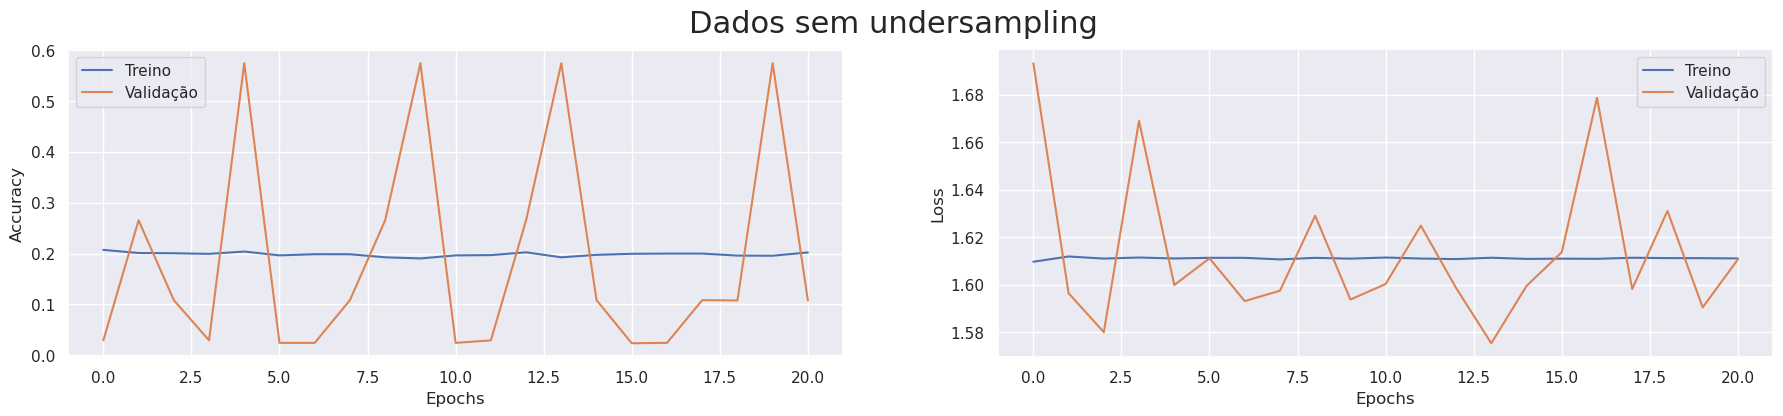

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(22,4))
fig.suptitle('Dados sem undersampling', fontsize=22) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
axs[0].plot(history_complete_data.history['accuracy'],label='Treino')
axs[0].plot(history_complete_data.history['val_accuracy'],label='Validação')
axs[0].set(ylabel='Accuracy')
axs[0].set(xlabel='Epochs')
axs[0].legend()

axs[1].plot(history_complete_data.history['loss'],label='Treino')
axs[1].plot(history_complete_data.history['val_loss'],label='Validação')
axs[1].set(ylabel='Loss')
axs[1].set(xlabel='Epochs')
axs[1].legend()




### Analisar Resultados

In [ ]:
classes=['Nota 1','Nota 2','Nota 3','Nota 4','Nota 5']

In [ ]:
neural_net_complete_data.evaluate(x_val_lemman,y_val_encoded)

361/633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0297 - loss: 1.6909

633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0294 - loss: 1.6919


[1.6932499408721924, 0.029413219541311264]

In [ ]:
y_pred_complete=neural_net_complete_data.predict(x_val_lemman)


238/633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
cm_complete=confusion_matrix(np.argmax(y_val_encoded,axis=1),np.argmax(y_pred_complete,axis=1))
cm_complete

array([[    0,   480,     0,     0,     0],
       [    0,   595,     0,     0,     0],
       [    0,  2180,     0,     0,     0],
       [    0,  5366,     0,     0,     0],
       [    0, 11608,     0,     0,     0]])

In [ ]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(conf_mat=cm_complete,
                                colorbar=False,
                                show_absolute=True,
                                 show_normed=True,
                              class_names=classes)

NameError: name 'cm_complete' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
cm_undersampling=confusion_matrix(np.argmax(y_teste_pp,axis=1),np.argmax(y_pred_undersampling,axis=1))
cm_undersampling

array([[ 300,   65,   44,   18,   53],
       [ 246,  122,  124,   26,   77],
       [ 298,  323,  876,  313,  370],
       [ 362,  341, 1255, 1189, 2219],
       [ 768,  488, 1184, 1845, 7323]])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 1200x800 with 0 Axes>

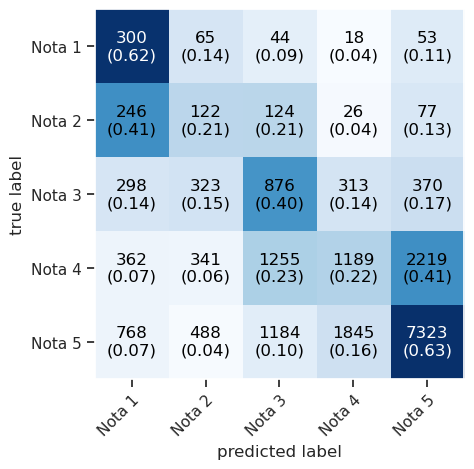

In [ ]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(conf_mat=cm_undersampling,
                                colorbar=False,
                                show_absolute=True,
                                 show_normed=True,
                              class_names=classes)

### Gridsearch

Ajustar alguns parâmetros em busca da melhor acurácia possível.
Para combinar o gridsearch do sklearn com modelo criado no keras será usada a biblioteca scikeras


#### Comparar algumas funções de ativação e número de neurônios nas duas camadas totalmente conectadas

In [ ]:
def get_model(hidden_layer_dim,activation,dropout_rate):

    neural_net=Sequential()
    neural_net.add(Input(shape=x_treino_pp.shape[1:]))
    neural_net.add(Dense(hidden_layer_dim,activation=activation))
    neural_net.add(Dropout(dropout_rate))
    neural_net.add(Dense(hidden_layer_dim,activation=activation))
    neural_net.add(Dropout(dropout_rate))
    neural_net.add(Dense(y_treino_pp.shape[1]))
    neural_net.add(Activation("softmax"))
    opt=optimizers.Adam(learning_rate=lr)
    neural_net.compile(loss='categorical_crossentropy',optimizer=opt)
    return neural_net

neural_model = KerasClassifier(
    model=get_model,
    hidden_layer_dim=10,
    activation='relu',
    optimizer="adam",
    epochs=100,
    dropout_rate=0.2)

#neural_model.fit(x_treino_pp,y_treino_pp)

params = {
    "hidden_layer_dim": [10, 20, 30],
    'activation':['relu','sigmoid','tanh'],
    'dropout_rate':np.arange(0,0.6,0.1)}

#gs = GridSearchCV(neural_model, params, refit=False, cv=3)
#gs.fit(x_treino_pp,y_treino_pp)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
200/200 [==============================] - 9s 23ms/step - loss: 1.1687
Epoch 2/100
200/200 [==============================] - 5s 25ms/step - loss: 1.0466
Epoch 3/100
200/200 [==============================] - 5s 27ms/step - loss: 1.0202
Epoch 4/100
200/200 [==============================] - 5s 24ms/step - loss: 0.9902
Epoch 5/100
200/200 [=========================

In [ ]:
#print(gs.best_score_, gs.best_params_)
'''
OS melhores parâmetros encontrados no gridsearch foram os seguintes:

0.13 {'activation': 'sigmoid', 'hidden_layer_dim': 20}
'''

0.13 {'activation': 'sigmoid', 'hidden_layer_dim': 20}


# Modelos para Processamento de Linguagem Natural


#### Criação do vocabulário

In [ ]:
#Dados que serão usados para o treinamento da LSTM

#x_LSTM_treino     =x_treino_lemann_undersampled
x_LSTM_val        =x_val_lemman
x_LSTM_teste      =x_teste_lemamn

dados_vocab=x_treino_lemman

In [ ]:
def criar_vocabulario(dados_treino, max_words_vocab):
    '''
    Função que cria uma lista com todas as palavram que apareceram no conunto de dados de treino
    Essa lista terá uma palavra para padding e outra para indicar que a palavra não foi encontrada no vocabulário

    <pad> - Foi adicionado em certos comentários para que todos os comentários tenham um mesmo número de comentário
    <oov> - out of vocabulary. Usado para indicar que uma palavra não está no vocabulário

    Inputs:
    dados_treino    - dados que serão usados para o treinamento dos modelos. Numpy array com amostras nas linhas e palavras nas colunas
    max_words_vocab - número máximo de palavras que entrarão no vocabulário.

    '''
    vocab=Counter()
    for i in dados_treino:
        vocab.update(i)
    vocab=[word for word, count in vocab.most_common()[:max_words_vocab]]
    vocab=vocab+['oov']
    return vocab


In [ ]:
size_vocab=10000
vocab_LSTM=criar_vocabulario(dados_vocab,10000)

In [ ]:
#Os dados de treinamento para as LSTM serão o indexes de cada palavra no vocabulário criado

def converter_tokens_LSTM(dados_tokens,vocab):
    num_rows,num_cols=np.shape(dados_tokens)
    dados_numericos=np.zeros([num_rows,num_cols])
    for row in range(num_rows):
        for col in range(num_cols):
            if dados_tokens[row,col] in vocab:
                dados_numericos[row,col]=vocab.index(dados_tokens[row,col])
        else:
            dados_numericos[row,col]=vocab.index('oov')
    return dados_numericos


In [ ]:
#x_LSTM_treino_numerico=converter_tokens_LSTM(x_LSTM_treino,vocab_LSTM)
x_LSTM_val_numerico   =converter_tokens_LSTM(x_LSTM_val,vocab_LSTM)
x_LSTM_teste_numerico =converter_tokens_LSTM(x_LSTM_teste,vocab_LSTM)

In [ ]:
teste_no_undersampling=converter_tokens_LSTM(dados_vocab,vocab_LSTM)

## LSTM

In [ ]:
sequence_length=25
embedding_size=128
dropout_rate=0.3
n_units=128
size_vocab=10000


In [ ]:
def attention_Luong(c):
  c[1]=tf.expand_dims(c[1],axis=-1)
  attention_weights=tf.matmul(c[0],c[1])
  attention_weights=tf.nn.softmax(attention_weights,axis=1)
  context_vector=c[0]*attention_weights
  context_vector=tf.reduce_sum(context_vector,axis=1)
  return context_vector

In [ ]:
#com attention
x_in=x=Input(shape=25)
x=Embedding(input_dim=len(vocab_LSTM),output_dim=embedding_size)(x)
x=Bidirectional(LSTM(units=n_units,dropout=dropout_rate,return_sequences=True),merge_mode='concat')(x)
x=Bidirectional(LSTM(units=n_units,dropout=dropout_rate,return_sequences=True),merge_mode='concat')(x)
(x, forward_h, forward_c, backward_h, backward_c) =Bidirectional(LSTM(units=n_units,dropout=dropout_rate,return_state=True,return_sequences=True),merge_mode='concat')(x)
state_h=Concatenate()([forward_h,backward_h])
context_vector=Lambda(attention_Luong)([x,state_h])
x_out=Dense(5,activation='softmax')(context_vector)

In [ ]:
#Sem attention
x_in=x=Input(shape=25)
x=Embedding(input_dim=len(vocab_LSTM),output_dim=embedding_size)(x)
x=Bidirectional(LSTM(units=n_units,dropout=dropout_rate,return_sequences=True),merge_mode='concat')(x)
x=Bidirectional(LSTM(units=n_units,dropout=dropout_rate,return_sequences=True),merge_mode='concat')(x)
x=Bidirectional(LSTM(units=n_units,dropout=dropout_rate),merge_mode='concat')(x)
x_out=Dense(5,activation='softmax')(x)

In [ ]:
model=Model(inputs=x_in,outputs=x_out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 25, 128)      1280000     ['input_13[0][0]']               
                                                                                                  
 bidirectional_27 (Bidirectiona  (None, 25, 256)     263168      ['embedding_10[0][0]']           
 l)                                                                                               
                                                                                                  
 bidirectional_28 (Bidirectiona  (None, 25, 256)     394240      ['bidirectional_27[0][0]'] 

In [ ]:
history=model.fit(x=teste_no_undersampling,y=y_treino_encoded
                  ,epochs=50,validation_data=[x_LSTM_val_numerico,y_val_encoded])

Epoch 1/50


2023/2023 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.5986 - loss: 0.9849 - val_accuracy: 0.6340 - val_loss: 0.8419
Epoch 2/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.6522 - loss: 0.7979 - val_accuracy: 0.6368 - val_loss: 0.8323
Epoch 3/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.6686 - loss: 0.7558 - val_accuracy: 0.6298 - val_loss: 0.8428
Epoch 4/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - accuracy: 0.6916 - loss: 0.7148 - val_accuracy: 0.6270 - val_loss: 0.8605
Epoch 5/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - accuracy: 0.7033 - loss: 0.6904 - val_accuracy: 0.6291 - val_loss: 0.8808
Epoch 6/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 89s 36ms/step - accuracy: 0.7243 - loss: 0.6515 - val_accuracy: 0.6274 - val_loss: 0.9050
Epoch 7/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 73s 32ms/step - accuracy: 0.7431 - loss: 0.6154 - val_accuracy: 0.6186 - val_loss: 0.9504
Epoch 8/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.7546 - loss: 0.58

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

633/633 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

Testados:

[32,32,32,32], dropout=0.3, LSTM, acc=0.8210
[64,64,64,64], dropout=0.3, LSTM, acc=0.8322
[128,128,128,128], dropout=0.3, LSTM, acc=0.8322
[128,128,128,128], dropout=0.3, Bidirecional, acc=0.8419
[64,64,64,64]    , dropout=0.3, Bidirecional,acc=8294
